In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# representation of model layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import joblib
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

# **ĐỌC DỮ LIỆU**

In [ ]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import cudf  # Dùng cuDF để xử lý dữ liệu nhanh hơn trên GPU

# Định nghĩa thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Hàm gộp nhãn thành 2 nhãn: Attack và Benign
def change_label(df):
    attack_labels = {
        'DDoS-ICMP_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood',
        'DDoS-PSHACK_Flood', 'DDoS-SYN_Flood', 'DDoS-RSTFINFlood',
        'DDoS-SynonymousIP_Flood', 'DDoS-ICMP_Fragmentation',
        'DDoS-UDP_Fragmentation', 'DDoS-ACK_Fragmentation',
        'DDoS-HTTP_Flood', 'DDoS-SlowLoris', 'DoS-UDP_Flood',
        'DoS-TCP_Flood', 'DoS-SYN_Flood', 'DoS-HTTP_Flood',
        'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan',
        'Recon-PingSweep', 'VulnerabilityScan', 'MITM-ArpSpoofing',
        'DNS_Spoofing', 'DictionaryBruteForce', 'BrowserHijacking',
        'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection',
        'Backdoor_Malware', 'Mirai-greeth_flood', 'Mirai-udpplain',
        'Mirai-greip_flood'
    }

    # Thay thế tất cả nhãn attack thành "Attack"
    df["label"] = df["label"].replace(to_replace=list(attack_labels), value="Attack")
    
    # Thay thế "BenignTraffic" thành "Benign"
    df["label"] = df["label"].replace("BenignTraffic", "Benign")
    return df

# Đọc dữ liệu từ thư mục
data_dir = "/kaggle/input/cic-iot-2023/"
file_list = glob.glob(f"{data_dir}*.csv")[:134]  # Lấy tối đa 100 file

# Giới hạn tối đa 1,000,000 dòng cho mỗi nhãn (Attack và Benign)
MAX_ROWS_PER_LABEL = 865_840
label_counts = {"Attack": 0, "Benign": 0}  # Theo dõi số dòng của từng nhãn

def read_file(filename, index):
    try:
        # Đọc file CSV bằng cuDF
        df = cudf.read_csv(filename)
        
        # Kiểm tra cột 'label'
        if 'label' not in df.columns:
            print(f"❌ File {filename}: Không tìm thấy cột 'label'!")
            return None
        
        # Gộp nhãn thành Attack và Benign
        df = change_label(df)
        
        # Lọc dữ liệu dựa trên giới hạn 1M cho mỗi nhãn
        valid_rows = []
        unique_labels = df['label'].unique().to_pandas().tolist()
        for label in unique_labels:
            current_count = label_counts.get(label, 0)
            remaining_quota = MAX_ROWS_PER_LABEL - current_count
            
            if remaining_quota <= 0:
                print(f"⚠ Nhãn {label} đã đủ {MAX_ROWS_PER_LABEL:,} dòng, không đọc thêm!")
                continue
            
            # Lấy các dòng thuộc nhãn này
            label_df = df[df['label'] == label]
            rows_to_take = min(len(label_df), remaining_quota)
            
            if rows_to_take > 0:
                valid_rows.append(label_df[:rows_to_take])
                label_counts[label] = current_count + rows_to_take
                print(f"📌 Nhãn {label}: Thêm {rows_to_take:,} dòng, tổng cộng {label_counts[label]:,} dòng")
        
        # Gộp các dòng hợp lệ
        if valid_rows:
            df_filtered = cudf.concat(valid_rows, ignore_index=True)
            print(f"📌 File {index}: Giữ {df_filtered.shape[0]:,} dòng sau khi lọc giới hạn")
            return df_filtered
        else:
            print(f"⚠ File {index}: Không có dữ liệu nào được giữ lại!")
            return None
    except Exception as e:
        print(f"❌ Lỗi khi đọc file {filename}: {e}")
        return None

# Đọc tuần tự từng file
dfs = []
for idx, fname in enumerate(file_list):
    df = read_file(fname, idx)
    if df is not None:
        dfs.append(df)

# Nối dữ liệu và vẽ biểu đồ
if dfs:
    df_full = cudf.concat(dfs, ignore_index=True)
    print(f"✅ Dữ liệu đã được nối! Kích thước: {df_full.shape}")
    print(f"📋 Nhãn duy nhất: {df_full['label'].unique().to_pandas().tolist()}")
    
    # Chuyển sang pandas để vẽ biểu đồ
    df_pandas = df_full.to_pandas()
    
    # Kiểm tra phân bố nhãn
    print("\n📋 Phân bố nhãn sau khi gộp:")
    print(df_pandas["label"].value_counts())
    
    # Vẽ biểu đồ phân bố nhãn
    fig, ax = plt.subplots(figsize=(8, 4))
    label_counts = df_pandas["label"].value_counts()

    bars = ax.bar(label_counts.index, label_counts.values, width=0.4, color=['blue', 'red'])
    plt.xticks(rotation=0, ha='center', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Attack vs Benign Labels (Max 1M per Label)')

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution_2labels_1M.png')  # Lưu biểu đồ
    plt.show()
    
    # Lưu dữ liệu để sử dụng ở các bước sau
    # df_pandas.to_csv(f"{output_dir}/data_2labels_1M.csv", index=False)
    # print(f"📦 Dữ liệu đã được lưu tại {output_dir}/data_2labels_1M.csv")
else:
    print("⚠ Không có file nào được đọc thành công hoặc tất cả dữ liệu rỗng!")

# **ÁNH XẠ NHÃN**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
import pickle
import os
import matplotlib.pyplot as plt

# Đường dẫn lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Giả định df_full là DataFrame từ cell đọc dữ liệu trước đó (cuDF)
# Chuyển từ cuDF sang Pandas
df_original = df_full.to_pandas()

# Kiểm tra dữ liệu đầu vào
if df_original.empty or 'label' not in df_original.columns:
    raise ValueError("❌ Dữ liệu đầu vào rỗng hoặc thiếu cột 'label'!")

# Xử lý giá trị thiếu cho cột số
numeric_columns = df_original.select_dtypes(include=[np.number]).columns
df_original[numeric_columns] = df_original[numeric_columns].fillna(df_original[numeric_columns].mean())

# Tách đặc trưng và nhãn
X = df_original.drop(columns=['label']).select_dtypes(include=[np.number])
y = df_original['label']

# Kiểm tra nhãn duy nhất
print("📋 Nhãn duy nhất trong dữ liệu:", y.unique().tolist())

# Sử dụng danh sách đặc trưng cố định
top_features = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']

# Kiểm tra xem các đặc trưng có tồn tại trong dữ liệu không
missing_features = [f for f in top_features if f not in X.columns]
if missing_features:
    raise ValueError(f"❌ Các đặc trưng sau không tồn tại trong dữ liệu: {missing_features}")

# Lấy chỉ số của các đặc trưng đã chọn
feature_indices = [list(X.columns).index(f) for f in top_features]

# Áp dụng các đặc trưng đã chọn trước khi chia dữ liệu
X = X[top_features]

# Chia dữ liệu thành tập train, val, test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.1875, stratify=Y_temp, random_state=42)

# Mã hóa nhãn (2 nhãn: Benign = 0, Attack = 1)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("📊 Ánh xạ nhãn (2 nhãn):", label_mapping)

# Kiểm tra phân bố nhãn
print("\n📊 Phân bố nhãn trong tập huấn luyện:")
print(pd.Series(Y_train_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))
print("\n📊 Phân bố nhãn trong tập validation:")
print(pd.Series(Y_val_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))
print("\n📊 Phân bố nhãn trong tập kiểm tra:")
print(pd.Series(Y_test_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))

# Xử lý NaN và outlier bằng KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu bằng RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Kiểm tra giá trị sau khi chọn đặc trưng
print("🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:")
print(pd.DataFrame(X_train_scaled, columns=top_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_val_scaled:")
print(pd.DataFrame(X_val_scaled, columns=top_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_test_scaled:")
print(pd.DataFrame(X_test_scaled, columns=top_features).describe().loc[['min', 'max']])

# Lưu dữ liệu đã xử lý
np.save(f"{output_dir}/X_train_scaled_2labels.npy", X_train_scaled)
np.save(f"{output_dir}/Y_train_encoded_2labels.npy", Y_train_encoded)
np.save(f"{output_dir}/X_val_scaled_2labels.npy", X_val_scaled)
np.save(f"{output_dir}/Y_val_encoded_2labels.npy", Y_val_encoded)
np.save(f"{output_dir}/X_test_scaled_2labels.npy", X_test_scaled)
np.save(f"{output_dir}/Y_test_encoded_2labels.npy", Y_test_encoded)

# Lưu các đối tượng xử lý
with open(f"{output_dir}/label_encoder_2labels.pkl", 'wb') as f:
    pickle.dump(label_encoder, f)
with open(f"{output_dir}/scaler_2labels.pkl", 'wb') as f:
    pickle.dump(scaler, f)
with open(f"{output_dir}/imputer_2labels.pkl", 'wb') as f:
    pickle.dump(imputer, f)
with open(f"{output_dir}/selected_features_2labels.pkl", 'wb') as f:
    pickle.dump(top_features, f)

# In thông tin chi tiết
print(f"✅ Dữ liệu đã xử lý và lưu trong '{output_dir}'!")
print(f"📌 Số đặc trưng được chọn: {len(top_features)}")
print(f"📋 Các đặc trưng được chọn: {top_features}")

# Vẽ biểu đồ danh sách đặc trưng được chọn
plt.figure(figsize=(10, 6))
plt.bar(top_features, [1] * len(top_features), color='skyblue')
plt.title('Selected Features for Classification', fontsize=12, fontweight='bold')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Selected', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{output_dir}/selected_features_2labels.png")
plt.show()

# **CHUYỂN ĐỔI ĐẶC TRƯNG FUZZY**

In [ ]:
import numpy as np
import time
from xgboost import XGBClassifier
from tqdm import tqdm
import os
import joblib

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Tải dữ liệu (2 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Hàm tính đặc trưng fuzzy bằng XGBoost với GPU
def convert_to_fuzzy_features_xgb(X_train, Y_train, X_val, X_test, n_features=10, n_labels=2, n_estimators=50):
    X_train_fuzzy = []
    X_val_fuzzy = []
    X_test_fuzzy = []
    
    # Lặp qua từng đặc trưng
    for i in tqdm(range(n_features), desc="Processing features"):
        # Lấy đặc trưng i từ tập train, val, test
        X_train_feature = X_train[:, i].reshape(-1, 1)
        X_val_feature = X_val[:, i].reshape(-1, 1)
        X_test_feature = X_test[:, i].reshape(-1, 1)
        
        # Huấn luyện XGBoost cho đặc trưng i
        xgb = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=10,
            min_child_weight=10,
            tree_method="hist",  # Optimized for GPU
            device="cuda",       # Enable GPU acceleration
            random_state=44,
            objective="binary:logistic"  # For binary classification
        )
        xgb.fit(X_train_feature, Y_train)
        
        # Dự đoán xác suất cho mỗi nhãn
        train_probs = xgb.predict_proba(X_train_feature)  # [n_samples, 2]
        val_probs = xgb.predict_proba(X_val_feature)
        test_probs = xgb.predict_proba(X_test_feature)
        
        # Thêm xác suất vào danh sách đặc trưng fuzzy
        X_train_fuzzy.append(train_probs)
        X_val_fuzzy.append(val_probs)
        X_test_fuzzy.append(test_probs)
        
        # Lưu mô hình XGBoost cho đặc trưng i
        joblib.dump(xgb, f"{output_dir}/xgb_feature_{i}_2labels.joblib")
    
    # Chuyển thành ma trận [n_samples, n_features * n_labels]
    X_train_fuzzy = np.concatenate(X_train_fuzzy, axis=1)  # [n_samples, 10*2]
    X_val_fuzzy = np.concatenate(X_val_fuzzy, axis=1)
    X_test_fuzzy = np.concatenate(X_test_fuzzy, axis=1)
    
    return X_train_fuzzy, X_val_fuzzy, X_test_fuzzy

# Tính đặc trưng fuzzy
tqdm.write("🔄 Tính đặc trưng fuzzy bằng XGBoost...")
start_time = time.time()
X_train_fuzzy, X_val_fuzzy, X_test_fuzzy = convert_to_fuzzy_features_xgb(
    X_train_scaled, Y_train_encoded, X_val_scaled, X_test_scaled, n_features=10, n_labels=2
)
tqdm.write(f"✅ Input shape (sau khi áp dụng fuzzy XGB): train {X_train_fuzzy.shape}, val {X_val_fuzzy.shape}, test {X_test_fuzzy.shape}")
tqdm.write(f"⏱ Thời gian tính fuzzy: {time.time() - start_time:.2f}s")

# Kiểm tra giá trị nan/inf
tqdm.write(f"X_train_fuzzy nan: {np.any(np.isnan(X_train_fuzzy))}")
tqdm.write(f"X_train_fuzzy inf: {np.any(np.isinf(X_train_fuzzy))}")
tqdm.write(f"X_val_fuzzy nan: {np.any(np.isnan(X_val_fuzzy))}")
tqdm.write(f"X_val_fuzzy inf: {np.any(np.isinf(X_val_fuzzy))}")
tqdm.write(f"X_test_fuzzy nan: {np.any(np.isnan(X_test_fuzzy))}")
tqdm.write(f"X_test_fuzzy inf: {np.any(np.isinf(X_test_fuzzy))}")

# Lưu dữ liệu fuzzy
np.save(f"{output_dir}/X_train_fuzzy_xgb_2labels.npy", X_train_fuzzy)
np.save(f"{output_dir}/X_val_fuzzy_xgb_2labels.npy", X_val_fuzzy)
np.save(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy", X_test_fuzzy)
tqdm.write(f"📦 Đã lưu dữ liệu fuzzy tại {output_dir}")

# **MÔ HÌNH DCN-V2**

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.amp import GradScaler, autocast

# FocalLoss (không thay đổi)
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# GhostBN1d (không thay đổi)
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# Cập nhật CrossLayer
class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, input_dim) * 0.01)
        self.bias = nn.Parameter(torch.zeros(input_dim))
        self.norm = nn.LayerNorm(input_dim)
        nn.init.xavier_normal_(self.weight, gain=0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x_0, x_l):
        # x_0: đầu vào ban đầu của Cross Network [batch_size, input_dim]
        # x_l: đầu ra của CrossLayer trước đó [batch_size, input_dim]
        assert x_0.dim() == 2 and x_l.dim() == 2, f"Expected 2D tensors, got x_0: {x_0.shape}, x_l: {x_l.shape}"
        x_l_w = torch.matmul(x_l, self.weight)  # x_l * w_l [batch_size, input_dim]
        x_l_w_b = x_l_w + self.bias  # x_l * w_l + b_l [batch_size, input_dim]
        x_0_dot = x_0 * x_l_w_b  # x_0 * (x_l * w_l + b_l) [batch_size, input_dim]
        x_l_plus_1 = x_0_dot + x_l  # x_0 * (x_l * w_l + b_l) + x_l [batch_size, input_dim]
        x_l_plus_1 = self.norm(x_l_plus_1)
        return x_l_plus_1

# Cập nhật DCNV2
class DCNV2(nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=64):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.cross_layers = nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                nn.Linear(prev_dim, deep_layer_dim),
                nn.BatchNorm1d(deep_layer_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = deep_layer_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine_fc = nn.Linear(input_dim + deep_layer_dim, num_classes)
        nn.init.xavier_normal_(self.combine_fc.weight, gain=0.1)
        nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        x_0 = x  # Đầu vào ban đầu cho Cross Network
        x_cross = x  # Khởi tạo x_cross cho lớp CrossLayer đầu tiên
        for i, layer in enumerate(self.cross_layers):
            x_cross = layer(x_0, x_cross)  # Truyền x_0 và x_cross
            if torch.isnan(x_cross).any():
                tqdm.write(f"NaN detected in CrossLayer {i+1}")
                break
        x_deep = self.deep(x)
        if torch.isnan(x_deep).any():
            tqdm.write("NaN detected in Deep layers")
        combined = torch.cat([x_cross, x_deep], dim=1)
        output = self.combine_fc(combined)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]
        return output, sparsity_loss, masks

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu fuzzy từ XGBoost (2 nhãn)
try:
    X_train_fuzzy = np.load(f"{output_dir}/X_train_fuzzy_xgb_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_fuzzy = np.load(f"{output_dir}/X_val_fuzzy_xgb_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_fuzzy = np.load(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu fuzzy XGBoost và nhãn (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra và xử lý NaN/Inf trong dữ liệu
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} contains NaN or Inf values")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_fuzzy = check_and_clean_data(X_train_fuzzy, "X_train_fuzzy")
X_val_fuzzy = check_and_clean_data(X_val_fuzzy, "X_val_fuzzy")
X_test_fuzzy = check_and_clean_data(X_test_fuzzy, "X_test_fuzzy")

# Chuẩn hóa dữ liệu
X_train_fuzzy = (X_train_fuzzy - X_train_fuzzy.mean(axis=0)) / (X_train_fuzzy.std(axis=0) + 1e-6)
X_val_fuzzy = (X_val_fuzzy - X_val_fuzzy.mean(axis=0)) / (X_val_fuzzy.std(axis=0) + 1e-6)
X_test_fuzzy = (X_test_fuzzy - X_test_fuzzy.mean(axis=0)) / (X_test_fuzzy.std(axis=0) + 1e-6)
# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_fuzzy, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fuzzy, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_fuzzy, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 4096
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Tính alpha cho Focal Loss
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_fuzzy.shape[1]  # 20 (từ 10 đặc trưng * 2 nhãn)
model = DCNV2(input_dim=input_dim, num_classes=2, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler('cuda')

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Tham số huấn luyện
num_epochs = 100
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
epoch_times = []

# Phân tích nhầm lẫn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['Benign', 'Attack']  # Cập nhật tên nhãn

# Huấn luyện
tqdm.write("Bắt đầu huấn luyện DCN-V2 với Focal + Sparsity Loss (Không Early Stopping)")
torch.manual_seed(44)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Huấn luyện Batch (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
            
            if torch.isnan(total_loss):
                tqdm.write(f"Phát hiện NaN trong total_loss tại batch {pbar.n+1}")
                continue
            
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean()
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Xác thực (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                with autocast('cuda'):
                    outputs, sparsity_loss, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    # Phân tích nhầm lẫn
    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Ma trận nhầm lẫn:\n{cm}")
    tqdm.write(f"Top cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

    # Lưu mô hình nếu F1 tốt hơn
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/dcnv2_2labels_fuzzy_xgb.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/dcnv2_2labels_fuzzy_xgb_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/dcnv2_2labels_fuzzy_xgb_final.pth")

# Lưu dữ liệu đánh giá
np.save(f"{results_dir}/train_losses_2labels_fuzzy_xgb_dcnv2.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_dcnv2.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_fuzzy_xgb_dcnv2.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_dcnv2.npy", np.array(val_accuracies))
np.save(f"{results_dir}/val_f1_scores_2labels_fuzzy_xgb_dcnv2.npy", np.array(val_f1_scores))
np.save(f"{results_dir}/val_precisions_2labels_fuzzy_xgb_dcnv2.npy", np.array(val_precisions))
np.save(f"{results_dir}/val_recalls_2labels_fuzzy_xgb_dcnv2.npy", np.array(val_recalls))
np.save(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_dcnv2.npy", np.array(epoch_times))

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/dcnv2_2labels_fuzzy_xgb.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Kiểm tra", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=2)
test_acc = accuracy_score(test_labels, test_preds) * 100
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

# Phân tích nhầm lẫn trên tập test
confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Ma trận nhầm lẫn (Test): {cm.shape}")
if cm.shape != (2, 2):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Ma trận nhầm lẫn không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Ma trận nhầm lẫn:\n{cm}")
tqdm.write(f"Cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Cảnh báo: Kích thước mask không đồng nhất: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_dcnv2.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_fuzzy_xgb_dcnv2.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels_fuzzy_xgb_dcnv2.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels_fuzzy_xgb_dcnv2.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_dcnv2.npy", avg_mask)

# Tính giá trị trung bình
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)
avg_f1 = np.mean(val_f1_scores)
avg_precision = np.mean(val_precisions)
avg_recall = np.mean(val_recalls)
total_time = sum(epoch_times)

# Lưu kết quả vào file DCN-v2.txt
with open(f"{results_dir}/DCN-v2.txt", 'w') as f:
    f.write("Kết quả huấn luyện DCN-V2\n")
    f.write("=====================\n")
    f.write(f"Train Loss trung bình: {avg_train_loss:.4f}\n")
    f.write(f"Val Loss trung bình: {avg_val_loss:.4f}\n")
    f.write(f"Train Accuracy trung bình: {avg_train_acc:.2f}%\n")
    f.write(f"Val Accuracy trung bình: {avg_val_acc:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Tổng thời gian huấn luyện: {total_time:.2f}s\n")
    f.write(f"F1 trung bình: {avg_f1:.4f}\n")
    f.write(f"Precision trung bình: {avg_precision:.4f}\n")
    f.write(f"Recall trung bình: {avg_recall:.4f}\n")
tqdm.write(f"📝 Đã lưu kết quả vào {results_dir}/DCN-v2.txt")

# In thông tin shape
tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Val F1 Scores shape: {np.array(val_f1_scores).shape}")
tqdm.write(f"Val Precisions shape: {np.array(val_precisions).shape}")
tqdm.write(f"Val Recalls shape: {np.array(val_recalls).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")


**VẼ CÁC SƠ ĐỒ DCN-V2**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/AutoInt-2nhan-Lan2/results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_dcnv2.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_dcnv2.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_dcnv2.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_dcnv2.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_dcnv2.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_fuzzy_xgb_dcnv2.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_fuzzy_xgb_dcnv2.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_fuzzy_xgb_dcnv2.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_dcnv2.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_dcnv2.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho DCN-V2 (2 nhãn, fuzzy XGBoost, 1 giai đoạn)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 100  # 100 epoch
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if test_features.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_features ({test_features.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_features = test_features[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {
    0: 'Benign',
    1: 'Attack'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(len(train_losses))
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs  # Sử dụng trực tiếp 0-99

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)  # Nét liền
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)  # Nét liền
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 99)
ax1.set_xticks(np.arange(0, 100, 20))  # 0, 20, 40, 60, 80

# Điều chỉnh trục Y để làm nổi bật sự biến thiên
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min())  # Bỏ epoch 0 để tránh giá trị bất thường
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max())
ax1.set_ylim(loss_min - 0.002, loss_max + 0.002)  # Thu hẹp phạm vi Y
ax1.set_yticks(np.linspace(loss_min - 0.002, loss_max + 0.002, 6))  # Tăng số điểm chia nhỏ

# Thêm đường ngang tại giá trị trung bình
avg_train_loss = np.mean(train_losses_plot[1:])  # Bỏ epoch 0
avg_val_loss = np.mean(val_losses_plot[1:])
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (99, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (99, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)  # Nét liền
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)  # Nét liền
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 99)
ax2.set_xticks(np.arange(0, 100, 20))  # 0, 20, 40, 60, 80

# Điều chỉnh trục Y để làm nổi bật sự biến thiên
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min())  # Bỏ epoch 0
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max())
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)  # Thu hẹp phạm vi Y
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))  # Tăng số điểm chia nhỏ

# Thêm đường ngang tại giá trị trung bình
avg_train_accuracy = np.mean(train_accuracies_plot[1:])  # Bỏ epoch 0
avg_val_accuracy = np.mean(val_accuracies_plot[1:])
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (99, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (99, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

# Thêm tiêu đề chính
plt.suptitle("DCN-V2: Learning Curves (2 Labels, Fuzzy XGBoost, Single Stage)\n100 Epochs", 
             fontsize=16, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_dcnv2_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))  # Giảm kích thước vì chỉ có 2 nhãn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("DCN-V2: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_dcnv2_2labels_fuzzy_xgb.png")
plt.show()

# 4️⃣ ROC-AUC (Binary classification) - Vẽ ROC cho cả hai nhãn
plt.figure(figsize=(8, 6))

# ROC cho nhãn Attack (nhãn 1)
fpr_attack, tpr_attack, _ = roc_curve(test_labels, test_probs[:, 1], pos_label=1)  # Nhãn Attack là dương
roc_auc_attack = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr_attack, tpr_attack, label=f"ROC Attack (AUC = {roc_auc_attack:.4f})", color="blue")

# ROC cho nhãn Benign (nhãn 0)
fpr_benign, tpr_benign, _ = roc_curve(test_labels, test_probs[:, 0], pos_label=0)  # Nhãn Benign là dương
roc_auc_benign = roc_auc_score(test_labels, test_probs[:, 0])
plt.plot(fpr_benign, tpr_benign, label=f"ROC Benign (AUC = {roc_auc_benign:.4f})", color="orange")

# Đường chéo tham chiếu
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("DCN-V2: ROC Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curves_dcnv2_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

print(f"📈 ROC-AUC Score (Attack): {roc_auc_attack:.4f}")
print(f"📈 ROC-AUC Score (Benign): {roc_auc_benign:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 1], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("DCN-V2: PCA 3D Visualization (2 Labels, Fuzzy XGBoost)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_dcnv2_2labels_fuzzy_xgb.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
# Giả định feature_importance có shape (batch_size, input_dim), lấy trung bình theo batch
if len(feature_importance.shape) == 2:
    avg_importance = np.mean(feature_importance, axis=0)
else:
    avg_importance = feature_importance

# Tạo nhãn cho các đặc trưng (input_dim=20, từ 10 đặc trưng * 2 nhãn)
input_dim = 20  # Từ code huấn luyện/test
feature_labels = [f"F{i//2}_P{label_map[i%2]}" for i in range(input_dim)]  # Ví dụ: F0_PBenign, F0_PAttack, F1_PBenign, ...

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_importance)), avg_importance, tick_label=feature_labels)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.title("DCN-V2: Feature Importance (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{results_dir}/feature_importance_dcnv2_2labels_fuzzy_xgb.png")
plt.show()

# 7️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 8️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình (100 epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Thư mục lưu dữ liệu
output_dir = "/kaggle/input/ketqua/DNCv2_2Nhan_Lan2/results"
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    X_test_fuzzy = np.load(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_fuzzy_xgb_dcnv2.npy")
    print(f"✅ Đã tải dữ liệu đặc trưng và nhãn")
    print(f"Shape of X_test_fuzzy: {X_test_fuzzy.shape}")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {
    0: 'Benign',
    1: 'Attack'
}

# Kiểm tra số mẫu và số chiều
n_samples, n_features = X_test_fuzzy.shape
if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_fuzzy has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    # Kiểm tra NaN/Inf trong X_test_fuzzy
    if np.any(np.isnan(X_test_fuzzy)) or np.any(np.isinf(X_test_fuzzy)):
        print("⚠️ X_test_fuzzy contains NaN or Inf values. Cleaning data...")
        X_test_fuzzy = np.nan_to_num(X_test_fuzzy, nan=0.0, posinf=1e6, neginf=-1e6)

    # Lấy mẫu ngẫu nhiên để giảm tải tính toán (nếu cần)
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_fuzzy_reduced = X_test_fuzzy[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_fuzzy_reduced = X_test_fuzzy
        test_labels_reduced = test_labels

    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_fuzzy_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        print(f"Tỷ lệ phương sai được giải thích: {pca.explained_variance_ratio_}")
        print(f"Tổng phương sai được giải thích: {sum(pca.explained_variance_ratio_):.4f}")

        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(
                pca_result[idx, 0],
                pca_result[idx, 1],
                pca_result[idx, 2],
                label=label_map[label],
                alpha=0.7,
                s=50
            )
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title("DCN-V2: PCA 3D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()

        # Lưu biểu đồ
        plt.savefig(f"{results_dir}/pca_3d_dcnv2_2labels_fuzzy_xgb.png", bbox_inches="tight")
        print(f"📊 Đã lưu biểu đồ PCA 3D vào {results_dir}/pca_3d_dcnv2_2labels_fuzzy_xgb.png")

        # Đóng biểu đồ để giải phóng bộ nhớ
        plt.close()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# **MÔ HÌNH FT-TRAN **

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 24.48 giây

📊 Giá trị trung bình (100 epoch):
Train Loss trung bình: 0.0017
Val Loss trung bình: 0.0017
Train Accuracy trung bình: 99.47%
Val Accuracy trung bình: 99.48%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.amp import GradScaler, autocast

# Định nghĩa các lớp FocalLoss, GhostBN1d và FTTransformerPure
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class FTTransformerPure(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, num_layers=3, num_heads=4, ff_hidden_dim=256, dropout=0.1):
        super(FTTransformerPure, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.ff_hidden_dim = ff_hidden_dim
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.feature_embed = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_hidden_dim, 
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc_output = nn.Linear(embed_dim, num_classes)
        self.importance_layer = nn.Linear(embed_dim, input_dim)

        # Khởi tạo trọng số
        nn.init.xavier_normal_(self.feature_embed.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)
        nn.init.zeros_(self.feature_embed.bias)
        nn.init.zeros_(self.fc_output.bias)
        nn.init.zeros_(self.importance_layer.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        x = self.feature_embed(x)  # Shape: [batch_size, embed_dim]
        x = self.ln(x)
        x = self.transformer(x.unsqueeze(1)).squeeze(1)  # Shape: [batch_size, embed_dim]
        embeddings = self.ln(x)
        output = self.fc_output(embeddings)  # Shape: [batch_size, num_classes]

        # Tính feature importance và sparsity loss
        importance = torch.sigmoid(self.importance_layer(embeddings))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        if torch.isnan(output).any() or torch.isnan(sparsity_loss).any():
            tqdm.write(f"NaN detected in output or sparsity_loss")
        
        return output, sparsity_loss, masks

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu fuzzy từ XGBoost (2 nhãn)
try:
    X_train_fuzzy = np.load(f"{output_dir}/X_train_fuzzy_xgb_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_fuzzy = np.load(f"{output_dir}/X_val_fuzzy_xgb_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_fuzzy = np.load(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu fuzzy XGBoost và nhãn (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra và xử lý NaN/Inf trong dữ liệu
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} contains NaN or Inf values")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_fuzzy = check_and_clean_data(X_train_fuzzy, "X_train_fuzzy")
X_val_fuzzy = check_and_clean_data(X_val_fuzzy, "X_val_fuzzy")
X_test_fuzzy = check_and_clean_data(X_test_fuzzy, "X_test_fuzzy")

# Chuẩn hóa dữ liệu
X_train_fuzzy = (X_train_fuzzy - X_train_fuzzy.mean(axis=0)) / (X_train_fuzzy.std(axis=0) + 1e-6)
X_val_fuzzy = (X_val_fuzzy - X_val_fuzzy.mean(axis=0)) / (X_val_fuzzy.std(axis=0) + 1e-6)
X_test_fuzzy = (X_test_fuzzy - X_test_fuzzy.mean(axis=0)) / (X_test_fuzzy.std(axis=0) + 1e-6)

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_fuzzy, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fuzzy, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_fuzzy, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 4096
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Tính alpha cho Focal Loss
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_fuzzy.shape[1]  # 20 (từ 10 đặc trưng * 2 nhãn)
model = FTTransformerPure(
    input_dim=input_dim,
    num_classes=2,  # Cập nhật số nhãn thành 2
    embed_dim=64,  # Giảm embed_dim vì ít đặc trưng hơn
    num_layers=3,  # Giảm số lớp để giảm độ phức tạp
    num_heads=4,
    ff_hidden_dim=256,  # Giảm ff_hidden_dim
    dropout=0.1
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler('cuda')

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Tham số huấn luyện
num_epochs = 100
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Phân tích nhầm lẫn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['Benign', 'Attack']  # Cập nhật tên nhãn cho 2 nhãn

# Huấn luyện
tqdm.write("Training FT-Transformer with Focal + Sparsity Loss (No Early Stopping)")
torch.manual_seed(44)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
            
            if torch.isnan(total_loss):
                tqdm.write(f"NaN detected in total_loss at batch {pbar.n+1}")
                continue
            
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean() if masks else 0.0
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                with autocast('cuda'):
                    outputs, sparsity_loss, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)  # Cập nhật cho 2 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    # Phân tích nhầm lẫn
    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")
    tqdm.write(f"Top cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

    # Lưu mô hình nếu F1 tốt hơn
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/fttransformer_2labels_fuzzy_xgb.pth")  # Cập nhật tên file
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/fttransformer_2labels_fuzzy_xgb_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/fttransformer_2labels_fuzzy_xgb_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels_fuzzy_xgb_fttransformer.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_fttransformer.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_fuzzy_xgb_fttransformer.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_fttransformer.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_fttransformer.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_2labels_fuzzy_xgb_fttransformer.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_2labels_fuzzy_xgb_fttransformer.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/fttransformer_2labels_fuzzy_xgb.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=2)  # Cập nhật cho 2 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

# Phân tích nhầm lẫn trên tập test
confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (2, 2):  # Cập nhật kích thước ma trận nhầm lẫn
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")
tqdm.write(f"Cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_fttransformer.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_fuzzy_xgb_fttransformer.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels_fuzzy_xgb_fttransformer.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels_fuzzy_xgb_fttransformer.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_fttransformer.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**CODE VẼ SƠ ĐỒ FT-TRAN**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_fttransformer.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_fttransformer.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_fttransformer.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_fttransformer.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_fttransformer.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_fuzzy_xgb_fttransformer.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_fuzzy_xgb_fttransformer.npy")
    X_test_fuzzy = np.load(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy")  # Tải dữ liệu đầu vào (20 đặc trưng)
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_fttransformer.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_fttransformer.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho FT-Transformer (2 nhãn, fuzzy XGBoost, 1 giai đoạn)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 100  # 100 epoch
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if X_test_fuzzy.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_fuzzy ({X_test_fuzzy.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    X_test_fuzzy = X_test_fuzzy[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {
    0: 'Benign',
    1: 'Attack'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(len(train_losses))
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs  # Sử dụng trực tiếp 0-99

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 99)
ax1.set_xticks(np.arange(0, 100, 20))

# Điều chỉnh trục Y để làm nổi bật sự biến thiên
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min())  # Bỏ epoch 0 để tránh giá trị bất thường
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max())
ax1.set_ylim(loss_min - 0.002, loss_max + 0.002)
ax1.set_yticks(np.linspace(loss_min - 0.002, loss_max + 0.002, 6))

# Thêm đường ngang tại giá trị trung bình
avg_train_loss = np.mean(train_losses_plot[1:])
avg_val_loss = np.mean(val_losses_plot[1:])
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (99, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (99, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 99)
ax2.set_xticks(np.arange(0, 100, 20))

# Điều chỉnh trục Y để làm nổi bật sự biến thiên
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min())
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max())
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))

# Thêm đường ngang tại giá trị trung bình
avg_train_accuracy = np.mean(train_accuracies_plot[1:])
avg_val_accuracy = np.mean(val_accuracies_plot[1:])
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (99, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (99, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

# Thêm tiêu đề chính
plt.suptitle("FT-Transformer: Learning Curves (2 Labels, Fuzzy XGBoost, Single Stage)\n100 Epochs", 
             fontsize=16, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_fttransformer_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("FT-Transformer: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_fttransformer_2labels_fuzzy_xgb.png")
plt.show()

# 4️⃣ ROC-AUC (Binary classification)
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])  # Sử dụng xác suất của nhãn Attack
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("FT-Transformer: ROC Curve (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_fttransformer_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Score (Binary): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_fuzzy: {X_test_fuzzy.shape}")
n_samples, n_features = X_test_fuzzy.shape

# Kiểm tra NaN/Inf trong X_test_fuzzy
if np.any(np.isnan(X_test_fuzzy)) or np.any(np.isinf(X_test_fuzzy)):
    print("⚠️ X_test_fuzzy contains NaN or Inf values. Cleaning data...")
    X_test_fuzzy = np.nan_to_num(X_test_fuzzy, nan=0.0, posinf=1e6, neginf=-1e6)

# Kiểm tra số mẫu và số chiều
if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_fuzzy has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_fuzzy)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title("FT-Transformer: PCA 3D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_fttransformer_2labels_fuzzy_xgb.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
# Đảm bảo feature_importance có shape (20,)
if len(feature_importance.shape) != 1 or feature_importance.shape[0] != 20:
    print(f"⚠️ Unexpected shape of feature_importance: {feature_importance.shape}. Expected (20,).")
    if len(feature_importance.shape) == 2:
        feature_importance = np.mean(feature_importance, axis=0)
    else:
        raise ValueError("Cannot process feature_importance with this shape.")

# Tạo nhãn cho các đặc trưng (input_dim=20, từ 10 đặc trưng * 2 nhãn)
input_dim = 20
feature_labels = [f"F{i//2}_P{label_map[i%2]}" for i in range(input_dim)]

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance, tick_label=feature_labels)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.title("FT-Transformer: Feature Importance (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{results_dir}/feature_importance_fttransformer_2labels_fuzzy_xgb.png")
plt.show()

# 7️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 8️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình (100 epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **MÔ HÌNH TABR**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.amp import GradScaler, autocast

# FocalLoss
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

# GhostBN1d
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# Retrieval-Augmented Layer
class RetrievalAugmentedLayer(nn.Module):
    def __init__(self, embed_dim, num_classes, k=5):
        super(RetrievalAugmentedLayer, self).__init__()
        self.k = k
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.attention = nn.Linear(embed_dim, 1)

    def forward(self, x_embed, labels=None):
        batch_size = x_embed.size(0)
        distances = torch.cdist(x_embed, x_embed)
        distances.fill_diagonal_(float('inf'))
        _, indices = torch.topk(distances, k=self.k, dim=1, largest=False)
        
        if labels is not None:
            neighbor_labels = labels[indices]
            neighbor_one_hot = F.one_hot(neighbor_labels, num_classes=self.num_classes).float()
        else:
            neighbor_one_hot = torch.zeros(batch_size, self.k, self.num_classes, device=x_embed.device)
        
        neighbor_embeddings = x_embed[indices]
        attention_scores = self.attention(neighbor_embeddings).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)
        context = torch.einsum('bk,bkc->bc', attention_weights, neighbor_one_hot)
        return context

# TabR
class TabR(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, n_layers=2, n_heads=4, ff_dim=128, dropout=0.1, k_neighbors=5):
        super(TabR, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout = dropout
        self.k_neighbors = k_neighbors

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.embedding = nn.Linear(input_dim, embed_dim)
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=n_layers)
        self.retrieval = RetrievalAugmentedLayer(embed_dim, num_classes, k=k_neighbors)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        self.fc_output = nn.Linear(embed_dim + num_classes, num_classes)

        nn.init.xavier_normal_(self.embedding.weight)
        nn.init.xavier_normal_(self.importance_layer.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, labels=None):
        x = torch.clamp(self.bn(x), -50, 50)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        x_embed = self.embedding(x)
        transformer_out = self.transformer(x_embed.unsqueeze(1)).squeeze(1)
        context = self.retrieval(x_embed, labels)
        combined = torch.cat([transformer_out, context], dim=1)
        output = self.fc_output(combined)
        return output, sparsity_loss, masks

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu fuzzy từ XGBoost
try:
    X_train_fuzzy = np.load(f"{output_dir}/X_train_fuzzy_xgb_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_fuzzy = np.load(f"{output_dir}/X_val_fuzzy_xgb_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_fuzzy = np.load(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu fuzzy XGBoost và nhãn (2 nhãn, 20 đặc trưng)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra và xử lý NaN/Inf
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} contains NaN or Inf values")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_fuzzy = check_and_clean_data(X_train_fuzzy, "X_train_fuzzy")
X_val_fuzzy = check_and_clean_data(X_val_fuzzy, "X_val_fuzzy")
X_test_fuzzy = check_and_clean_data(X_test_fuzzy, "X_test_fuzzy")

# Chuẩn hóa dữ liệu
try:
    X_train_fuzzy = (X_train_fuzzy - X_train_fuzzy.mean(axis=0)) / (X_train_fuzzy.std(axis=0) + 1e-6)
    X_val_fuzzy = (X_val_fuzzy - X_val_fuzzy.mean(axis=0)) / (X_val_fuzzy.std(axis=0) + 1e-6)
    X_test_fuzzy = (X_test_fuzzy - X_test_fuzzy.mean(axis=0)) / (X_test_fuzzy.std(axis=0) + 1e-6)
except Exception as e:
    tqdm.write(f"❌ Lỗi khi chuẩn hóa dữ liệu: {str(e)}")
    raise

# Kiểm tra NaN/Inf sau chuẩn hóa
if np.any(np.isnan(X_train_fuzzy)) or np.any(np.isinf(X_train_fuzzy)):
    tqdm.write("⚠️ X_train_fuzzy vẫn chứa NaN hoặc Inf sau chuẩn hóa!")
if np.any(np.isnan(X_val_fuzzy)) or np.any(np.isinf(X_val_fuzzy)):
    tqdm.write("⚠️ X_val_fuzzy vẫn chứa NaN hoặc Inf sau chuẩn hóa!")
if np.any(np.isnan(X_test_fuzzy)) or np.any(np.isinf(X_test_fuzzy)):
    tqdm.write("⚠️ X_test_fuzzy vẫn chứa NaN hoặc Inf sau chuẩn hóa!")

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_fuzzy, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_fuzzy, dtype=torch.float32).to(device)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fuzzy, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long).to(device)

# DataLoader
batch_size = 4096
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Tính alpha cho Focal Loss
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# Khởi tạo mô hình
input_dim = X_train_fuzzy.shape[1]  # 20
model = TabR(
    input_dim=input_dim,
    num_classes=2,
    embed_dim=64,
    n_layers=2,
    n_heads=4,
    ff_dim=128,
    dropout=0.1,
    k_neighbors=5
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler('cuda')

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Tham số huấn luyện
num_epochs = 100
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []
epoch_times = []

# Phân tích nhầm lẫn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['Benign', 'Attack']

# Huấn luyện
tqdm.write("Training TabR with Focal + Sparsity Loss (2 Labels, 20 Features, Batch Retrieval, No Early Stopping)")
torch.manual_seed(44)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch, labels=Y_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
            
            if torch.isnan(total_loss):
                tqdm.write(f"NaN detected in total_loss at batch {pbar.n+1}")
                continue
            
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean() if masks else 0.0
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                with autocast('cuda'):
                    outputs, sparsity_loss, _ = model(X_batch, labels=Y_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")
    tqdm.write(f"Top cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

    # Lưu mô hình sau mỗi epoch
    torch.save(model.state_dict(), f"{results_dir}/tabr_2labels_fuzzy_xgb_epoch_{epoch+1}.pth")
    tqdm.write(f"📦 Lưu mô hình tại epoch {epoch+1}")

    # Lưu mô hình nếu F1 tốt hơn
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/tabr_2labels_fuzzy_xgb.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/tabr_2labels_fuzzy_xgb_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/tabr_2labels_fuzzy_xgb_final.pth")

# Lưu dữ liệu đánh giá
np.save(f"{results_dir}/train_losses_2labels_fuzzy_xgb_tabr.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_tabr.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_fuzzy_xgb_tabr.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_tabr.npy", np.array(val_accuracies))
np.save(f"{results_dir}/val_f1_scores_2labels_fuzzy_xgb_tabr.npy", np.array(val_f1_scores))
np.save(f"{results_dir}/val_precisions_2labels_fuzzy_xgb_tabr.npy", np.array(val_precisions))
np.save(f"{results_dir}/val_recalls_2labels_fuzzy_xgb_tabr.npy", np.array(val_recalls))
np.save(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_tabr.npy", np.array(epoch_times))
tqdm.write(f"📝 Đã lưu các file đánh giá .npy cho TabR")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/tabr_2labels_fuzzy_xgb.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast('cuda'):
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=2)
test_acc = accuracy_score(test_labels, test_preds) * 100
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (2, 2):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")
tqdm.write(f"Cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")

if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_tabr.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_fuzzy_xgb_tabr.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels_fuzzy_xgb_tabr.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels_fuzzy_xgb_tabr.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_tabr.npy", avg_mask)

avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)
avg_f1 = np.mean(val_f1_scores)
avg_precision = np.mean(val_precisions)
avg_recall = np.mean(val_recalls)
total_time = sum(epoch_times)

with open(f"{results_dir}/TabR_2labels_fuzzy_xgb.txt", 'w') as f:
    f.write("Kết quả huấn luyện TabR\n")
    f.write("=====================\n")
    f.write(f"Train Loss trung bình: {avg_train_loss:.4f}\n")
    f.write(f"Val Loss trung bình: {avg_val_loss:.4f}\n")
    f.write(f"Train Accuracy trung bình: {avg_train_acc:.2f}%\n")
    f.write(f"Val Accuracy trung bình: {avg_val_acc:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc:.2f}%\n")
    f.write(f"Tổng thời gian huấn luyện: {total_time:.2f}s\n")
    f.write(f"F1 trung bình: {avg_f1:.4f}\n")
    f.write(f"Precision trung bình: {avg_precision:.4f}\n")
    f.write(f"Recall trung bình: {avg_recall:.4f}\n")
tqdm.write(f"📝 Đã lưu kết quả vào {results_dir}/TabR_2labels_fuzzy_xgb.txt")

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Val F1 Scores shape: {np.array(val_f1_scores).shape}")
tqdm.write(f"Val Precisions shape: {np.array(val_precisions).shape}")
tqdm.write(f"Val Recalls shape: {np.array(val_recalls).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**VẼ CÁC SƠ ĐỒ**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_tabr.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_tabr.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_tabr.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_tabr.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_tabr.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_fuzzy_xgb_tabr.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_fuzzy_xgb_tabr.npy")
    X_test_fuzzy = np.load(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy")  # Tải dữ liệu đầu vào (20 đặc trưng)
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_tabr.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_tabr.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho TabR (2 nhãn, fuzzy XGBoost, 1 giai đoạn)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
num_epochs = len(train_losses)  # Số epoch thực tế (có thể dừng sớm)
if train_losses.shape != (num_epochs,) or val_losses.shape != (num_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (num_epochs,) or val_accuracies.shape != (num_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if X_test_fuzzy.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_fuzzy ({X_test_fuzzy.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    X_test_fuzzy = X_test_fuzzy[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {
    0: 'Benign',
    1: 'Attack'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(num_epochs)
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, num_epochs - 1)
ax1.set_xticks(np.arange(0, num_epochs, max(1, num_epochs // 5)))

# Điều chỉnh trục Y để làm nổi bật sự biến thiên
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min()) if len(train_losses_plot) > 1 else min(train_losses_plot)
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max()) if len(train_losses_plot) > 1 else max(train_losses_plot)
ax1.set_ylim(loss_min - 0.002, loss_max + 0.002)
ax1.set_yticks(np.linspace(loss_min - 0.002, loss_max + 0.002, 6))

# Thêm đường ngang tại giá trị trung bình
avg_train_loss = np.mean(train_losses_plot[1:]) if len(train_losses_plot) > 1 else np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot[1:]) if len(val_losses_plot) > 1 else np.mean(val_losses_plot)
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (num_epochs-1, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (num_epochs-1, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, num_epochs - 1)
ax2.set_xticks(np.arange(0, num_epochs, max(1, num_epochs // 5)))

# Điều chỉnh trục Y để làm nổi bật sự biến thiên
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min()) if len(train_accuracies_plot) > 1 else min(train_accuracies_plot)
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max()) if len(train_accuracies_plot) > 1 else max(train_accuracies_plot)
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))

# Thêm đường ngang tại giá trị trung bình
avg_train_accuracy = np.mean(train_accuracies_plot[1:]) if len(train_accuracies_plot) > 1 else np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot[1:]) if len(val_accuracies_plot) > 1 else np.mean(val_accuracies_plot)
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (num_epochs-1, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (num_epochs-1, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

# Thêm tiêu đề chính
plt.suptitle(f"TabR: Learning Curves (2 Labels, Fuzzy XGBoost, Single Stage)\n{num_epochs} Epochs", 
             fontsize=16, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_tabr_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("TabR: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_tabr_2labels_fuzzy_xgb.png")
plt.show()

# 4️⃣ ROC-AUC (Binary classification)
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])  # Sử dụng xác suất của nhãn Attack
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("TabR: ROC Curve (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_tabr_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Score (Binary): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_fuzzy: {X_test_fuzzy.shape}")
n_samples, n_features = X_test_fuzzy.shape

# Kiểm tra NaN/Inf trong X_test_fuzzy
if np.any(np.isnan(X_test_fuzzy)) or np.any(np.isinf(X_test_fuzzy)):
    print("⚠️ X_test_fuzzy contains NaN or Inf values. Cleaning data...")
    X_test_fuzzy = np.nan_to_num(X_test_fuzzy, nan=0.0, posinf=1e6, neginf=-1e6)

# Kiểm tra số mẫu và số chiều
if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_fuzzy has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    # Lấy mẫu ngẫu nhiên để giảm tải tính toán (nếu cần)
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_fuzzy_reduced = X_test_fuzzy[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_fuzzy_reduced = X_test_fuzzy
        test_labels_reduced = test_labels

    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_fuzzy_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title("TabR: PCA 3D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_tabr_2labels_fuzzy_xgb.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
# Đảm bảo feature_importance có shape (20,)
if len(feature_importance.shape) != 1 or feature_importance.shape[0] != 20:
    print(f"⚠️ Unexpected shape of feature_importance: {feature_importance.shape}. Expected (20,).")
    if len(feature_importance.shape) == 2:
        feature_importance = np.mean(feature_importance, axis=0)
    else:
        raise ValueError("Cannot process feature_importance with this shape.")

# Tạo nhãn cho các đặc trưng (input_dim=20, từ 10 đặc trưng * 2 nhãn)
input_dim = 20
feature_labels = [f"F{i//2}_P{label_map[i%2]}" for i in range(input_dim)]

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance, tick_label=feature_labels)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.title("TabR: Feature Importance (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{results_dir}/feature_importance_tabr_2labels_fuzzy_xgb.png")
plt.show()

# 7️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 8️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình (100 epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **MÔ HÌNH AUTOINT**

Top cặp nhầm lẫn: [('BENIGN', 'Attack', 1890)]
📦 Lưu mô hình cuối cùng tại results/autoint_2labels_20features_final.pth
📊 Tổng thời gian huấn luyện: 2068.91s
📊 Thời gian huấn luyện trung bình mỗi epoch: 20.69s
Testing: 100%|██████████| 85/85 [00:03<00:00, 21.42batch/s, test_loss=0.1582]
🔍 Kích thước Confusion Matrix (Test): (2, 2)

📊 Kết quả trên tập test:
Test Acc: 99.46%, F1: 0.9946, Precision: 0.9946, Recall: 0.9946
Phân bố dự đoán (Test): [171717 174619]
Confusion Matrix:
[[171507   1661]
 [   210 172958]]
Cặp nhầm lẫn: [('BENIGN', 'Attack', 1871)]
Train Losses shape: (100,)
Train Accuracies shape: (100,)
Val Losses shape: (100,)
Val Accuracies shape: (100,)
Epoch Times shape: (100,)
Average Epoch Time: 20.69s
Confusion Matrix shape: (2, 2)
Test Probs shape: (346336, 2)
Test Labels shape: (346336,)
Test Features shape: (346336, 2)
Feature Importance shape: (20,)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os
from torch.amp import GradScaler, autocast  # SỬA: Cập nhật API AMP

# Định nghĩa các lớp FocalLoss, GhostBN1d, AutoInt
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.5, alpha=None, reduction='mean', label_smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # SỬA: Clamping logits để tránh giá trị cực đại
        inputs = torch.clamp(inputs, -100, 100)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        return loss

class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class AutoInt(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, n_layers=2, n_heads=4, dropout=0.1):
        super(AutoInt, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.embedding = nn.Linear(input_dim, embed_dim)
        nn.init.xavier_normal_(self.embedding.weight, gain=0.1)  # SỬA: Giảm gain

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, dropout=dropout, batch_first=True)
            for _ in range(n_layers)
        ])
        self.attention_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.dropout_layer = nn.Dropout(dropout)

        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)  # SỬA: Giảm gain

        self.fc_output = nn.Linear(embed_dim, num_classes)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)  # SỬA: Giảm gain
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        importance = torch.sigmoid(self.importance_layer(x))
        importance = torch.clamp(importance, min=1e-6, max=1-1e-6)
        sparsity_loss = torch.mean(-importance * torch.log(importance) - (1-importance) * torch.log(1-importance + 1e-6))
        masks = [importance]

        x_embed = self.embedding(x).unsqueeze(1)  # Shape: [batch_size, 1, embed_dim]
        for attn, norm in zip(self.attention_layers, self.attention_norms):
            attn_output, _ = attn(x_embed, x_embed, x_embed)
            x_embed = norm(x_embed + self.dropout_layer(attn_output))

        embeddings = x_embed.squeeze(1)  # Shape: [batch_size, embed_dim]
        output = self.fc_output(embeddings)  # Shape: [batch_size, num_classes]

        # SỬA: Kiểm tra NaN
        if torch.isnan(output).any() or torch.isnan(sparsity_loss).any():
            tqdm.write(f"NaN detected in output or sparsity_loss")

        return output, sparsity_loss, masks

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# SỬA: Tải dữ liệu fuzzy từ XGBoost cho 2 nhãn, 20 đặc trưng
try:
    X_train_fuzzy = np.load(f"{output_dir}/X_train_fuzzy_xgb_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_fuzzy = np.load(f"{output_dir}/X_val_fuzzy_xgb_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_fuzzy = np.load(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu fuzzy XGBoost và nhãn (2 nhãn, 20 đặc trưng)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# SỬA: Kiểm tra và xử lý NaN/Inf trong dữ liệu
def check_and_clean_data(X, name):
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        tqdm.write(f"⚠️ {name} contains NaN or Inf values")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    return X

X_train_fuzzy = check_and_clean_data(X_train_fuzzy, "X_train_fuzzy")
X_val_fuzzy = check_and_clean_data(X_val_fuzzy, "X_val_fuzzy")
X_test_fuzzy = check_and_clean_data(X_test_fuzzy, "X_test_fuzzy")

# SỬA: Chuẩn hóa dữ liệu để giảm scale
X_train_fuzzy = (X_train_fuzzy - X_train_fuzzy.mean(axis=0)) / (X_train_fuzzy.std(axis=0) + 1e-6)
X_val_fuzzy = (X_val_fuzzy - X_val_fuzzy.mean(axis=0)) / (X_val_fuzzy.std(axis=0) + 1e-6)
X_test_fuzzy = (X_test_fuzzy - X_test_fuzzy.mean(axis=0)) / (X_test_fuzzy.std(axis=0) + 1e-6)

# Chuyển thành tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_fuzzy, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fuzzy, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_fuzzy, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 4096  # Đồng bộ với DCN-V2/FT-Transformer/TabNet/NODE-GAM
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# SỬA: Tính alpha cho Focal Loss cho 2 nhãn
cls_num_list = np.bincount(Y_train_encoded)
alpha = torch.FloatTensor(1.0 / (cls_num_list + 1e-6)).to(device)
alpha /= alpha.sum()

# SỬA: Khởi tạo mô hình với num_classes=2, input_dim=20
input_dim = X_train_fuzzy.shape[1]  # 20
model = AutoInt(input_dim=input_dim, num_classes=2, embed_dim=64, n_layers=2, n_heads=4, dropout=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_focal = FocalLoss(gamma=3.5, alpha=alpha, label_smoothing=0.1)
scaler = GradScaler('cuda')  # SỬA: Cập nhật API

# Hàm loss tổng hợp
def combined_loss(outputs, Y_batch, criterion_focal, sparsity_loss):
    focal_loss = criterion_focal(outputs, Y_batch)
    total_loss = focal_loss + 5e-4 * sparsity_loss
    return total_loss, focal_loss, sparsity_loss

# Tham số huấn luyện
num_epochs = 100
best_f1 = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# SỬA: Phân tích nhầm lẫn cho 2 nhãn
def analyze_confusion_matrix(cm, label_names):
    confusion_pairs = []
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            if cm[i, j] > 0 or cm[j, i] > 0:
                confusion_pairs.append((label_names[i], label_names[j], cm[i, j] + cm[j, i]))
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    return confusion_pairs[:5]

label_names = ['BENIGN', 'Attack']  # SỬA: Cập nhật nhãn cho 2 lớp

# Huấn luyện
tqdm.write("Training AutoInt with Focal + Sparsity Loss (No Early Stopping, 2 Labels, 20 Features)")
torch.manual_seed(44)  # Đồng bộ với DCN-V2/FT-Transformer/TabNet/NODE-GAM
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            
            with autocast('cuda'):  # SỬA: Cập nhật API
                outputs, sparsity_loss, masks = model(X_batch)
                total_loss, focal_loss, sparsity_loss = combined_loss(
                    outputs, Y_batch, criterion_focal, sparsity_loss
                )
            
            # SỬA: Kiểm tra NaN trong loss
            if torch.isnan(total_loss):
                tqdm.write(f"NaN detected in total_loss at batch {pbar.n+1}")
                continue
            
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += total_loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})
            
            if pbar.n < 5 and epoch == 0:
                mask_sum = masks[-1].sum(dim=1).mean()
                tqdm.write(f"Batch {pbar.n+1}: Outputs max/min: {outputs.max():.4f}/{outputs.min():.4f}, "
                          f"Focal Loss: {focal_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, "
                          f"Grad Norm: {grad_norm:.4f}, Mask sum: {mask_sum:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                with autocast('cuda'):  # SỬA: Cập nhật API
                    outputs, sparsity_loss, _ = model(X_batch)
                    focal_loss = criterion_focal(outputs, Y_batch)
                    loss = focal_loss + 5e-4 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)  # SỬA: Cập nhật cho 2 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    # Phân tích nhầm lẫn
    confusion_pairs = analyze_confusion_matrix(cm, label_names)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")
    tqdm.write(f"Top cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")  # SỬA: Điều chỉnh thông điệp cho 2 nhãn

    # Lưu mô hình nếu F1 tốt hơn
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/autoint_2labels_20features.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# SỬA: Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/autoint_2labels_20features_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/autoint_2labels_20features_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels_20features_autoint.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_20features_autoint.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_20features_autoint.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_20features_autoint.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels_20features_autoint.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_2labels_20features_autoint.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_2labels_20features_autoint.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/autoint_2labels_20features.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            with autocast('cuda'):  # SỬA: Cập nhật API
                outputs, sparsity_loss, masks = model(X_batch)
                probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=2)  # SỬA: Cập nhật cho 2 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

# Phân tích nhầm lẫn trên tập test
confusion_pairs = analyze_confusion_matrix(cm, label_names)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (2, 2):  # SỬA: Cập nhật kiểm tra cho 2 nhãn
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")
tqdm.write(f"Cặp nhầm lẫn: {[(pair[0], pair[1], pair[2]) for pair in confusion_pairs]}")  # SỬA: Điều chỉnh thông điệp cho 2 nhãn

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels_20features_autoint.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_20features_autoint.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels_20features_autoint.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels_20features_autoint.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels_20features_autoint.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**VẼ CÁC SƠ ĐỒ AUTOINT**

📊 Giá trị trung bình (100 epoch):
Train Loss trung bình: 0.0020
Val Loss trung bình: 0.0019
Train Accuracy trung bình: 99.37%
Val Accuracy trung bình: 99.36%

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_20features_autoint.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_20features_autoint.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_20features_autoint.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_20features_autoint.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_20features_autoint.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_20features_autoint.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_20features_autoint.npy")
    X_test_fuzzy = np.load(f"{output_dir}/X_test_fuzzy_xgb_2labels.npy")  # Tải dữ liệu đầu vào (20 đặc trưng)
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_20features_autoint.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_20features_autoint.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho AutoInt (2 nhãn, fuzzy XGBoost, 20 đặc trưng)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
num_epochs = len(train_losses)  # Số epoch thực tế
if train_losses.shape != (num_epochs,) or val_losses.shape != (num_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (num_epochs,) or val_accuracies.shape != (num_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")

# Kiểm tra số mẫu đồng bộ
n_samples = len(test_labels)
if X_test_fuzzy.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_fuzzy ({X_test_fuzzy.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    X_test_fuzzy = X_test_fuzzy[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt để đồng bộ.")
    test_probs = test_probs[:n_samples]

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {
    0: 'Benign',
    1: 'Attack'
}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu cho biểu đồ
epochs = np.arange(num_epochs)
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ Loss (bên trái)
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, num_epochs - 1)
ax1.set_xticks(np.arange(0, num_epochs, max(1, num_epochs // 5)))

# Điều chỉnh trục Y để làm nổi bật sự biến thiên
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min()) if len(train_losses_plot) > 1 else min(train_losses_plot)
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max()) if len(train_losses_plot) > 1 else max(train_losses_plot)
ax1.set_ylim(loss_min - 0.002, loss_max + 0.002)
ax1.set_yticks(np.linspace(loss_min - 0.002, loss_max + 0.002, 6))

# Thêm đường ngang tại giá trị trung bình
avg_train_loss = np.mean(train_losses_plot[1:]) if len(train_losses_plot) > 1 else np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot[1:]) if len(val_losses_plot) > 1 else np.mean(val_losses_plot)
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
# Thêm chú thích giá trị tại epoch cuối
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (num_epochs-1, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (num_epochs-1, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

# Biểu đồ Accuracy (bên phải)
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, num_epochs - 1)
ax2.set_xticks(np.arange(0, num_epochs, max(1, num_epochs // 5)))

# Điều chỉnh trục Y để làm nổi bật sự biến thiên
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min()) if len(train_accuracies_plot) > 1 else min(train_accuracies_plot)
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max()) if len(train_accuracies_plot) > 1 else max(train_accuracies_plot)
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))

# Thêm đường ngang tại giá trị trung bình
avg_train_accuracy = np.mean(train_accuracies_plot[1:]) if len(train_accuracies_plot) > 1 else np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot[1:]) if len(val_accuracies_plot) > 1 else np.mean(val_accuracies_plot)
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
# Thêm chú thích giá trị tại epoch cuối
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (num_epochs-1, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (num_epochs-1, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

# Thêm tiêu đề chính
plt.suptitle(f"AutoInt: Learning Curves (2 Labels, Fuzzy XGBoost, 20 Features)\n{num_epochs} Epochs", 
             fontsize=16, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_autoint_2labels_20features.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("AutoInt: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_autoint_2labels_20features.png")
plt.show()

# 4️⃣ ROC-AUC (Binary classification)
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])  # Sử dụng xác suất của nhãn Attack
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("AutoInt: ROC Curve (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_autoint_2labels_20features.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Score (Binary): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_fuzzy: {X_test_fuzzy.shape}")
n_samples, n_features = X_test_fuzzy.shape

# Kiểm tra NaN/Inf trong X_test_fuzzy
if np.any(np.isnan(X_test_fuzzy)) or np.any(np.isinf(X_test_fuzzy)):
    print("⚠️ X_test_fuzzy contains NaN or Inf values. Cleaning data...")
    X_test_fuzzy = np.nan_to_num(X_test_fuzzy, nan=0.0, posinf=1e6, neginf=-1e6)

# Kiểm tra số mẫu và số chiều
if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_fuzzy has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    # Lấy mẫu ngẫu nhiên để giảm tải tính toán (nếu cần)
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_fuzzy_reduced = X_test_fuzzy[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_fuzzy_reduced = X_test_fuzzy
        test_labels_reduced = test_labels

    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_fuzzy_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title("AutoInt: PCA 3D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_autoint_2labels_20features.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
# Đảm bảo feature_importance có shape (20,)
if len(feature_importance.shape) != 1 or feature_importance.shape[0] != 20:
    print(f"⚠️ Unexpected shape of feature_importance: {feature_importance.shape}. Expected (20,).")
    if len(feature_importance.shape) == 2:
        feature_importance = np.mean(feature_importance, axis=0)
    else:
        raise ValueError("Cannot process feature_importance with this shape.")

# Tạo nhãn cho các đặc trưng (input_dim=20)
input_dim = 20
feature_labels = [f"Feature_{i+1}" for i in range(input_dim)]  # Đơn giản hóa nhãn đặc trưng

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance, tick_label=feature_labels)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.title("AutoInt: Feature Importance (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{results_dir}/feature_importance_autoint_2labels_20features.png")
plt.show()

# 7️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 8️⃣ In giá trị trung bình của Loss và Accuracy
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình (100 epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **CODE LẤY KẾT QẢU**

In [77]:
import os
import zipfile
from IPython.display import FileLink

# Đường dẫn đến các thư mục
processed_data_dir = "/kaggle/working/processed_data"
results_dir = "/kaggle/working/NODEGAM"

# Tạo file ZIP cho thư mục processed_data
# processed_zip = "/kaggle/working/processed_data.zip"
# with zipfile.ZipFile(processed_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(processed_data_dir):
#         for file in files:
#             file_path = os.path.join(root, file)
#             # Thêm file vào ZIP với đường dẫn tương đối
#             zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Tạo file ZIP cho thư mục results
results_zip = "/kaggle/working/results.zip"
with zipfile.ZipFile(results_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Thêm file vào ZIP với đường dẫn tương đối
            zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Hiển thị liên kết tải xuống
# print("Tải xuống processed_data.zip:")
# display(FileLink("processed_data.zip"))

print("Tải xuống results.zip:")
display(FileLink("results.zip"))

Tải xuống results.zip:


/kaggle/working/results.zip

# **VẼ LẠI CÁC SƠ ĐỒ**

In [ ]:
pip install captum

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import os
import joblib
import shap
import uuid
from mpl_toolkits.mplot3d import Axes3D  # Added for 3D PCA

# Định nghĩa lớp DCN-V2 (giữ nguyên cấu trúc với LayerNorm)
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, input_dim) * 0.01)
        self.bias = nn.Parameter(torch.zeros(input_dim))
        self.norm = nn.LayerNorm(input_dim)  # Giữ nguyên LayerNorm
        nn.init.xavier_normal_(self.weight, gain=0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x_0, x_l):
        x_l_w = torch.matmul(x_l, self.weight)
        x_l_w_b = x_l_w + self.bias
        x_0_dot = x_0 * x_l_w_b
        x_l_plus_1 = x_0_dot + x_l
        x_l_plus_1 = self.norm(x_l_plus_1)
        return x_l_plus_1

class DCNV2(nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=64):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.cross_layers = nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                nn.Linear(prev_dim, deep_layer_dim),
                nn.BatchNorm1d(deep_layer_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = deep_layer_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine_fc = nn.Linear(input_dim + deep_layer_dim, num_classes)
        nn.init.xavier_normal_(self.combine_fc.weight, gain=0.1)
        nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        x_0 = x
        x_cross = x
        for layer in self.cross_layers:
            x_cross = layer(x_0, x_cross)
        x_deep = self.deep(x)
        combined = torch.cat([x_cross, x_deep], dim=1)
        output = self.combine_fc(combined)
        importance = torch.sigmoid(self.importance_layer(x))
        return output

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/DNCv2_2Nhan_Lan2/results"
processed_dir = "processed_data"
Kq = "DCN-v2"
output_subdir = os.path.join(Kq)
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_dcnv2.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_dcnv2.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_dcnv2.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_dcnv2.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_dcnv2.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_fuzzy_xgb_dcnv2.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_fuzzy_xgb_dcnv2.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_fuzzy_xgb_dcnv2.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_dcnv2.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_dcnv2.npy")
    X_test_scaled = np.load(f"{processed_dir}/X_test_scaled_2labels.npy")
    X_test_fuzzy = np.load(f"{processed_dir}/X_test_fuzzy_xgb_2labels.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho DCN-V2 (2 nhãn, fuzzy XGBoost)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 100
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if X_test_fuzzy.shape[1] != 20:
    raise ValueError(f"X_test_fuzzy phải có 20 đặc trưng, nhưng có shape {X_test_fuzzy.shape}")

# Đồng bộ số mẫu
n_samples = len(test_labels)
if test_features.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_features ({test_features.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_features = test_features[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_probs = test_probs[:n_samples]
if X_test_scaled.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_scaled ({X_test_scaled.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    X_test_scaled = X_test_scaled[:n_samples]
if X_test_fuzzy.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_fuzzy ({X_test_fuzzy.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    X_test_fuzzy = X_test_fuzzy[:n_samples]

# Ánh xạ nhãn
label_map = {0: 'Benign', 1: 'Attack'}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu
epochs = np.arange(len(train_losses))
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 99)
ax1.set_xticks(np.arange(0, 100, 20))
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min())
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max())
ax1.set_ylim(loss_min - 0.00001, loss_max + 0.00001)
ax1.set_yticks(np.linspace(loss_min - 0.00001, loss_max + 0.00001, 6))
avg_train_loss = np.mean(train_losses_plot[1:])
avg_val_loss = np.mean(val_losses_plot[1:])
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (99, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (99, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 99)
ax2.set_xticks(np.arange(0, 100, 20))
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min())
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max())
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))
avg_train_accuracy = np.mean(train_accuracies_plot[1:])
avg_val_accuracy = np.mean(val_accuracies_plot[1:])
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (99, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (99, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

plt.suptitle("DCN-V2: Learning Curves (2 Labels, Fuzzy XGBoost)\n100 Epochs", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{Kq}/learning_curves_dcnv2_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("DCN-V2: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{Kq}/confusion_matrix_dcnv2_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 4️⃣ ROC-AUC
plt.figure(figsize=(8, 6))
fpr_attack, tpr_attack, _ = roc_curve(test_labels, test_probs[:, 1], pos_label=1)
roc_auc_attack = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr_attack, tpr_attack, label=f"ROC Attack (AUC = {roc_auc_attack:.4f})", color="blue", linewidth=2)
fpr_benign, tpr_benign, _ = roc_curve(test_labels, test_probs[:, 0], pos_label=0)
roc_auc_benign = roc_auc_score(test_labels == 0, test_probs[:, 0])
plt.plot(fpr_benign, tpr_benign, label=f"ROC Benign (AUC = {roc_auc_benign:.4f})", color="orange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Baseline")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("DCN-V2: ROC Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.savefig(f"{Kq}/roc_curves_dcnv2_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Score (Attack): {roc_auc_attack:.4f}")
print(f"📈 ROC-AUC Score (Benign): {roc_auc_benign:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_fuzzy: {X_test_fuzzy.shape}")
n_samples, n_features = X_test_fuzzy.shape

# Kiểm tra NaN/Inf trong X_test_fuzzy
if np.any(np.isnan(X_test_fuzzy)) or np.any(np.isinf(X_test_fuzzy)):
    print("⚠️ X_test_fuzzy contains NaN or Inf values. Cleaning data...")
    X_test_fuzzy = np.nan_to_num(X_test_fuzzy, nan=0.0, posinf=1e6, neginf=-1e6)

# Kiểm tra số mẫu và số chiều
if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_fuzzy has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    # Lấy mẫu ngẫu nhiên để giảm tải tính toán (nếu cần)
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_fuzzy_reduced = X_test_fuzzy[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_fuzzy_reduced = X_test_fuzzy
        test_labels_reduced = test_labels

    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_fuzzy_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title("DCN-V2: PCA 3D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{Kq}/pca_3d_dcn_2labels_fuzzy_xgb.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")


# # 6️⃣ Feature Importance
# print(f"Shape of feature_importance: {feature_importance.shape}")
# if len(feature_importance.shape) == 2:
#     avg_importance = np.mean(feature_importance, axis=0)
# else:
#     avg_importance = feature_importance

# n_original_features = 10
# avg_importance_original = np.zeros(n_original_features)
# for i in range(n_original_features):
#     avg_importance_original[i] = (avg_importance[2 * i] + avg_importance[2 * i + 1]) / 2

# feature_labels_original = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']
# print(f"📌 Số đặc trưng được chọn: {len(feature_labels_original)}")
# print(f"📋 Các đặc trưng được chọn: {feature_labels_original}")

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(avg_importance_original)), avg_importance_original, tick_label=feature_labels_original)
# plt.xlabel("Original Feature", fontsize=12)
# plt.ylabel("Importance Score (Averaged)", fontsize=12)
# plt.title("DCN-V2: Feature Importance (10 Original Features, Fuzzy XGBoost)", fontsize=14)
# plt.xticks(rotation=45, ha="right")
# plt.grid(True, linestyle="--", alpha=0.7)
# plt.tight_layout()
# plt.savefig(f"{Kq}/feature_importance_original_dcnv2_2labels_fuzzy_xgb.png", bbox_inches="tight")
# plt.show()

# top_k = 5
# indices_original = np.argsort(avg_importance_original)[::-1][:top_k]
# print(f"\n📌 Top {top_k} đặc trưng gốc quan trọng nhất:")
# for i, idx in enumerate(indices_original):
#     print(f"{i+1}. {feature_labels_original[idx]}: {avg_importance_original[idx]:.4f}")

# # Set up device and load the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# try:
#     model = DCNV2(input_dim=20, num_classes=2).to(device)
#     model.load_state_dict(torch.load(f"{results_dir}/dcnv2_2labels_fuzzy_xgb.pth", weights_only=True))
#     model.eval()
#     print("✅ Loaded DCN-V2 model successfully")

#     # Define prediction function for KernelExplainer
#     def predict_fn(inputs):
#         inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
#         with torch.no_grad():
#             outputs = model(inputs_tensor)
#         return outputs.cpu().numpy()

#     # Prepare data for SHAP
#     X_test_fuzzy_np = X_test_fuzzy[:50]  # Use 50 samples for SHAP (KernelExplainer is slow)
#     background = X_test_fuzzy_np[:10]  # Use 10 samples as background
#     explainer = shap.KernelExplainer(predict_fn, background)
#     shap_values = explainer.shap_values(X_test_fuzzy_np, nsamples=100)  # Compute SHAP for 50 samples

#     # SHAP values for the Attack label (index 1)
#     shap_values_attack = shap_values[1]  # Shape: (50, 20)
#     print(f"SHAP values (DCN-V2, Attack) shape: {shap_values_attack.shape}")

#     # Create fuzzy feature names
#     fuzzy_feature_names = [f"{feature_labels_original[i]}_{j}" for i in range(10) for j in ['Benign', 'Attack']]

#     # Improved SHAP Summary Plot for 20 fuzzy features with better styling
#     plt.figure(figsize=(12, 8))
#     shap.summary_plot(
#         shap_values_attack,
#         X_test_fuzzy_np,
#         feature_names=fuzzy_feature_names,
#         plot_type="dot",  # Use dot plot for clearer visualization
#         show=False,
#         max_display=20,  # Ensure all 20 features are shown
#         cmap=plt.cm.coolwarm,  # Use a more distinct color map (blue to red)
#         plot_size=None  # Let figure size control the plot dimensions
#     )
#     plt.title("SHAP Summary Plot (20 Fuzzy Features, DCN-V2)\nImpact on Attack Prediction", fontsize=16, pad=20)
#     plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=10)  # Adjust feature name font size
#     plt.gca().xaxis.set_tick_params(labelsize=10)  # Adjust SHAP value font size
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_summary_dcnv2_fuzzy_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     # Map SHAP values to 10 original features
#     shap_values_mapped = np.zeros((shap_values_attack.shape[0], 10))  # Shape: (50, 10)
#     for i in range(10):
#         # Take the maximum absolute SHAP value from the Benign and Attack pair
#         pair_values = shap_values_attack[:, [2*i, 2*i+1]]
#         abs_pair = np.abs(pair_values)
#         max_indices = np.argmax(abs_pair, axis=1)
#         for j in range(shap_values_attack.shape[0]):
#             shap_values_mapped[j, i] = pair_values[j, max_indices[j]]

#     # Map the data to 10 original features (average the Benign and Attack values)
#     X_test_mapped = np.zeros((X_test_fuzzy.shape[0], 10))
#     for i in range(10):
#         X_test_mapped[:, i] = np.mean(X_test_fuzzy[:, [2*i, 2*i+1]], axis=1)

#     # Improved SHAP Summary Plot for 10 original features with better styling
#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values_mapped,
#         X_test_mapped[:50],
#         feature_names=feature_labels_original,
#         plot_type="dot",  # Use dot plot for clarity
#         show=False,
#         max_display=10,  # Show all 10 features
#         cmap=plt.cm.coolwarm,  # Use a distinct color map
#         plot_size=None
#     )
#     plt.title("SHAP Summary Plot (10 Original Features, DCN-V2)\nImpact on Attack Prediction (Mapped)", fontsize=16, pad=20)
#     plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)  # Larger, non-rotated feature labels
#     plt.gca().xaxis.set_tick_params(labelsize=10)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_summary_dcnv2_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     # Improved SHAP Bar Plot for overall feature importance (10 original features)
#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values_mapped,
#         X_test_mapped[:50],
#         feature_names=feature_labels_original,
#         plot_type="bar",  # Use bar plot to show overall importance
#         show=False,
#         max_display=10,
#         color="#1f77b4"  # Use a single color for clarity
#     )
#     plt.title("SHAP Feature Importance (10 Original Features, DCN-V2)\nAverage Impact on Attack Prediction", fontsize=16, pad=20)
#     plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
#     plt.gca().xaxis.set_tick_params(labelsize=10)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_bar_dcnv2_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     # SHAP Force Plot for Attack sample (index 1) with improved styling
#     shap.initjs()  # Initialize JavaScript for force plot (optional if using matplotlib)
#     plt.figure(figsize=(12, 4))
#     shap.force_plot(
#         explainer.expected_value[1],
#         shap_values_mapped[1, :],
#         X_test_mapped[1, :],
#         feature_names=feature_labels_original,
#         matplotlib=True,
#         show=False,
#         text_rotation=15,  # Rotate feature names for better readability
#         figsize=(12, 4)
#     )
#     plt.title("SHAP Force Plot for Attack Sample (Index 1, DCN-V2)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_force_attack_dcnv2_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     # SHAP Force Plot for Benign sample (index 0) with improved styling
#     plt.figure(figsize=(12, 4))
#     shap.force_plot(
#         explainer.expected_value[1],
#         shap_values_mapped[0, :],
#         X_test_mapped[0, :],
#         feature_names=feature_labels_original,
#         matplotlib=True,
#         show=False,
#         text_rotation=15,
#         figsize=(12, 4)
#     )
#     plt.title("SHAP Force Plot for Benign Sample (Index 0, DCN-V2)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_force_benign_dcnv2_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     # Print top 5 most important original features based on SHAP
#     shap_values_mean = np.mean(np.abs(shap_values_mapped), axis=0)
#     top_k = 5
#     top_indices_shap = np.argsort(shap_values_mean)[::-1][:top_k]
#     print(f"\n📌 Top {top_k} most important original features (based on SHAP):")
#     for i, idx in enumerate(top_indices_shap):
#         print(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

#     # Calculate and print correlation between SHAP and feature importance
#     correlation = np.corrcoef(avg_importance_original, shap_values_mean)
#     print(f"\n📊 Correlation between feature importance (DCN-V2) and SHAP (mapped): {correlation[0, 1]:.4f}")

# except Exception as e:
#     print(f"❌ Error while computing SHAP values for DCN-V2: {str(e)}")

# # 8️⃣ Phân tích mẫu cụ thể
# predicted_labels = np.argmax(test_probs, axis=1)
# attack_idx = np.where(predicted_labels == 1)[0][0]
# benign_idx = np.where(predicted_labels == 0)[0][0]

# print(f"\n📌 Phân tích mẫu được dự đoán là 'Attack' (index {attack_idx}):")
# print(f"Xác suất dự đoán: Attack = {test_probs[attack_idx, 1]:.4f}, Benign = {test_probs[attack_idx, 0]:.4f}")
# print(f"Nhãn thực tế: {label_map[test_labels[attack_idx]]}")
# print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
# sample_features = X_test_scaled[attack_idx]
# top_k = 3
# top_indices = np.argsort(avg_importance_original)[::-1][:top_k]
# for idx in top_indices:
#     print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {sample_features[idx]:.4f})")

# print(f"\n📌 Phân tích mẫu được dự đoán unconditionally là 'Benign' (index {benign_idx}):")
# print(f"Xác suất dự đoán: Attack = {test_probs[benign_idx, 1]:.4f}, Benign = {test_probs[benign_idx, 0]:.4f}")
# print(f"Nhãn thực tế: {label_map[test_labels[benign_idx]]}")
# print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
# sample_features = X_test_scaled[benign_idx]
# for idx in top_indices:
#     print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {sample_features[idx]:.4f})")

# # 9️⃣ Thời gian huấn luyện và metric
# avg_time = np.mean(epoch_times)
# print(f"\n⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")
# avg_train_loss = np.mean(train_losses_plot)
# avg_val_loss = np.mean(val_losses_plot)
# avg_train_accuracy = np.mean(train_accuracies_plot)
# avg_val_accuracy = np.mean(val_accuracies_plot)
# print("\n📊 Giá trị trung bình (100 epoch):")
# print(f"Train Loss trung bình: {avg_train_loss:.4f}")
# print(f"Val Loss trung bình: {avg_val_loss:.4f}")
# print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
# print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

📁 Đảm bảo thư mục lưu kết quả: DCN-v2
✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy
⚠️ Cảnh báo: Dữ liệu Loss đã bị clip vào khoảng (0.0013, 0.004) để hiển thị.
⚠️ Cảnh báo: Dữ liệu Accuracy đã bị clip vào khoảng (0.991, 0.996) để hiển thị.


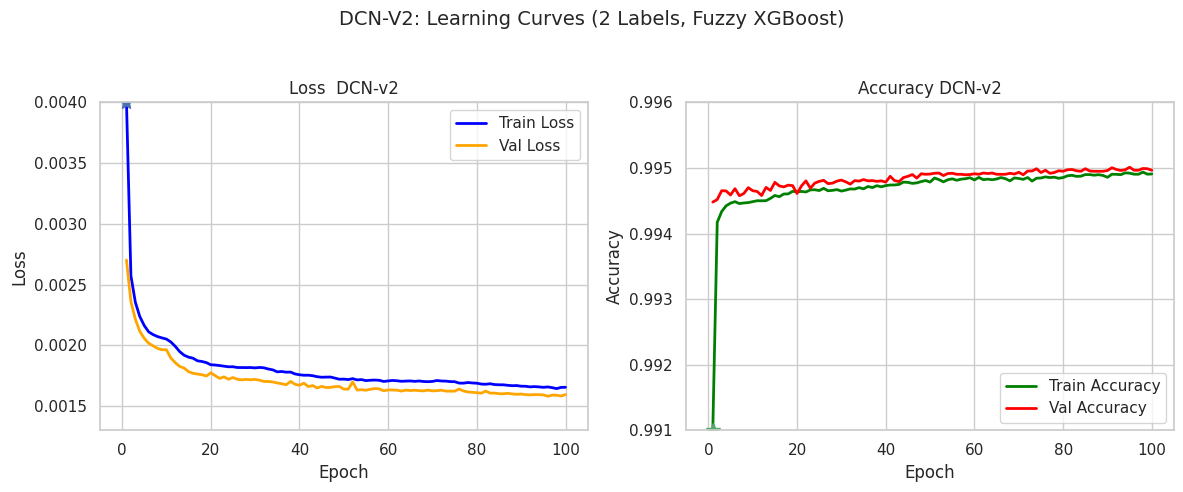

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Thư mục dữ liệu
results_dir = "/kaggle/input/ketqua/DNCv2_2Nhan_Lan2/results"
Kq = "DCN-v2"
output_subdir = Kq
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_dcnv2.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_dcnv2.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_dcnv2.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_dcnv2.npy")
    print("✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra dữ liệu
expected_epochs = 100
if (train_losses.shape != (expected_epochs,) or 
    val_losses.shape != (expected_epochs,) or 
    train_accuracies.shape != (expected_epochs,) or 
    val_accuracies.shape != (expected_epochs,)):
    raise ValueError("❌ Dữ liệu không đúng kích thước mong đợi")

# Chuyển accuracy về [0, 1] để hiển thị chính xác
train_acc = train_accuracies / 100.0
val_acc = val_accuracies / 100.0
epochs = np.arange(1, expected_epochs + 1)

# Kiểm tra và clip dữ liệu Loss và Accuracy
loss_ylim = (0.0013, 0.004)
acc_ylim = (0.991, 0.996)

# Clip Loss
train_losses_clipped = np.clip(train_losses, loss_ylim[0], loss_ylim[1])
val_losses_clipped = np.clip(val_losses, loss_ylim[0], loss_ylim[1])
if (np.any(train_losses != train_losses_clipped) or np.any(val_losses != val_losses_clipped)):
    print(f"⚠️ Cảnh báo: Dữ liệu Loss đã bị clip vào khoảng {loss_ylim} để hiển thị.")

# Clip Accuracy
train_acc_clipped = np.clip(train_acc, acc_ylim[0], acc_ylim[1])
val_acc_clipped = np.clip(val_acc, acc_ylim[0], acc_ylim[1])
if (np.any(train_acc != train_acc_clipped) or np.any(val_acc != val_acc_clipped)):
    print(f"⚠️ Cảnh báo: Dữ liệu Accuracy đã bị clip vào khoảng {acc_ylim} để hiển thị.")

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax1.plot(epochs, train_losses_clipped, label="Train Loss", color="blue", linewidth=2)
ax1.plot(epochs, val_losses_clipped, label="Val Loss", color="orange", linewidth=2)
ax1.set_title("Loss  DCN-v2")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.grid(True)

# Giới hạn trục x và y
ax1.set_xlim(-5, 105)
ax1.set_ylim(loss_ylim[0], loss_ylim[1])

# Đánh dấu các điểm bị clip (nếu có)
for i, (train_val, val_val) in enumerate(zip(train_losses, val_losses)):
    if train_val < loss_ylim[0] or train_val > loss_ylim[1]:
        ax1.plot(epochs[i], train_losses_clipped[i], 'b*', markersize=10)
    if val_val < loss_ylim[0] or val_val > loss_ylim[1]:
        ax1.plot(epochs[i], val_losses_clipped[i], 'o*', markersize=10)

# Accuracy plot
ax2.plot(epochs, train_acc_clipped, label="Train Accuracy", color="green", linewidth=2)
ax2.plot(epochs, val_acc_clipped, label="Val Accuracy", color="red", linewidth=2)
ax2.set_title("Accuracy DCN-v2")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.grid(True)
ax2.set_xlim(-5, 105)
ax2.set_ylim(acc_ylim[0], acc_ylim[1])

# Đánh dấu các điểm bị clip (nếu có)
for i, (train_val, val_val) in enumerate(zip(train_acc, val_acc)):
    if train_val < acc_ylim[0] or train_val > acc_ylim[1]:
        ax2.plot(epochs[i], train_acc_clipped[i], 'g*', markersize=10)
    if val_val < acc_ylim[0] or val_val > acc_ylim[1]:
        ax2.plot(epochs[i], val_acc_clipped[i], 'r*', markersize=10)

# Tiêu đề tổng
plt.suptitle("DCN-V2: Learning Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{output_subdir}/learning_curves_dcnv2_final.png", dpi=300)

# **VẼ SƠ ĐỒ FT-TRAN**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import os
import shap
from tqdm import tqdm

# Định nghĩa lại lớp GhostBN1d và FTTransformerPure
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class FTTransformerPure(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, num_layers=3, num_heads=4, ff_hidden_dim=256, dropout=0.1):
        super(FTTransformerPure, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.ff_hidden_dim = ff_hidden_dim
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.feature_embed = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_hidden_dim, 
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc_output = nn.Linear(embed_dim, num_classes)
        self.importance_layer = nn.Linear(embed_dim, input_dim)

        nn.init.xavier_normal_(self.feature_embed.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)
        nn.init.zeros_(self.feature_embed.bias)
        nn.init.zeros_(self.fc_output.bias)
        nn.init.zeros_(self.importance_layer.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        x = self.feature_embed(x)
        x = self.ln(x)
        x = self.transformer(x.unsqueeze(1)).squeeze(1)
        embeddings = self.ln(x)
        output = self.fc_output(embeddings)
        return output

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/FTTRAN-FUZZY-2NHAN/results"
processed_dir = "processed_data"
Kq = "FT-Tran"
output_subdir = os.path.join(Kq)
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_fttransformer.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_fttransformer.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_fttransformer.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_fttransformer.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_fttransformer.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_fuzzy_xgb_fttransformer.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_fuzzy_xgb_fttransformer.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_fuzzy_xgb_fttransformer.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_fttransformer.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_fttransformer.npy")
    X_test_scaled = np.load(f"{processed_dir}/X_test_fuzzy_xgb_2labels.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho FT-Transformer (2 nhãn, fuzzy XGBoost)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 100
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if X_test_scaled.shape[1] != 20:
    raise ValueError(f"X_test_scaled phải có 20 đặc trưng, nhưng có shape {X_test_scaled.shape}")

# Đồng bộ số mẫu
n_samples = len(test_labels)
if test_features.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_features ({test_features.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_features = test_features[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_probs = test_probs[:n_samples]
if X_test_scaled.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_scaled ({X_test_scaled.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    X_test_scaled = X_test_scaled[:n_samples]

# Ánh xạ nhãn
label_map = {0: 'Benign', 1: 'Attack'}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu
epochs = np.arange(len(train_losses))
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 99)
ax1.set_xticks(np.arange(0, 100, 20))
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min())
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max())
ax1.set_ylim(loss_min - 0.00001, loss_max + 0.00001)
ax1.set_yticks(np.linspace(loss_min - 0.00001, loss_max + 0.00001, 6))
avg_train_loss = np.mean(train_losses_plot[1:])
avg_val_loss = np.mean(val_losses_plot[1:])
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (99, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (99, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 99)
ax2.set_xticks(np.arange(0, 100, 20))
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min())
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max())
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))
avg_train_accuracy = np.mean(train_accuracies_plot[1:])
avg_val_accuracy = np.mean(val_accuracies_plot[1:])
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (99, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (99, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

plt.suptitle("FT-Transformer: Learning Curves (2 Labels, Fuzzy XGBoost)\n100 Epochs", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{Kq}/learning_curves_fttran_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("FT-Transformer: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{Kq}/confusion_matrix_fttran_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 4️⃣ ROC-AUC
plt.figure(figsize=(8, 6))
fpr_attack, tpr_attack, _ = roc_curve(test_labels, test_probs[:, 1], pos_label=1)
roc_auc_attack = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr_attack, tpr_attack, label=f"ROC Attack (AUC = {roc_auc_attack:.4f})", color="blue", linewidth=2)
fpr_benign, tpr_benign, _ = roc_curve(test_labels, test_probs[:, 0], pos_label=0)
roc_auc_benign = roc_auc_score(test_labels == 0, test_probs[:, 0])
plt.plot(fpr_benign, tpr_benign, label=f"ROC Benign (AUC = {roc_auc_benign:.4f})", color="orange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Baseline")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("FT-Transformer: ROC Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.savefig(f"{Kq}/roc_curves_fttran_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Score (Attack): {roc_auc_attack:.4f}")
print(f"📈 ROC-AUC Score (Benign): {roc_auc_benign:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_fuzzy: {X_test_fuzzy.shape}")
n_samples, n_features = X_test_fuzzy.shape

# Kiểm tra NaN/Inf trong X_test_fuzzy
if np.any(np.isnan(X_test_fuzzy)) or np.any(np.isinf(X_test_fuzzy)):
    print("⚠️ X_test_fuzzy contains NaN or Inf values. Cleaning data...")
    X_test_fuzzy = np.nan_to_num(X_test_fuzzy, nan=0.0, posinf=1e6, neginf=-1e6)

# Kiểm tra số mẫu và số chiều
if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_fuzzy has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    # Lấy mẫu ngẫu nhiên để giảm tải tính toán (nếu cần)
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_fuzzy_reduced = X_test_fuzzy[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_fuzzy_reduced = X_test_fuzzy
        test_labels_reduced = test_labels

    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_fuzzy_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title("FT-Transformer: PCA 3D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{Kq}/pca_3d_ft--tran_2labels_fuzzy_xgb.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# # 6️⃣ Feature Importance
# print(f"Shape of feature_importance: {feature_importance.shape}")
# if len(feature_importance.shape) == 2:
#     avg_importance = np.mean(feature_importance, axis=0)
# else:
#     avg_importance = feature_importance

# n_original_features = 10
# avg_importance_original = np.zeros(n_original_features)
# for i in range(n_original_features):
#     avg_importance_original[i] = (avg_importance[2 * i] + avg_importance[2 * i + 1]) / 2

# feature_labels_original = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']
# print(f"📌 Số đặc trưng được chọn: {len(feature_labels_original)}")
# print(f"📋 Các đặc trưng được chọn: {feature_labels_original}")

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(avg_importance_original)), avg_importance_original, tick_label=feature_labels_original)
# plt.xlabel("Original Feature", fontsize=12)
# plt.ylabel("Importance Score (Averaged)", fontsize=12)
# plt.title("FT-Transformer: Feature Importance (10 Original Features, Fuzzy XGBoost)", fontsize=14)
# plt.xticks(rotation=45, ha="right")
# plt.grid(True, linestyle="--", alpha=0.7)
# plt.tight_layout()
# plt.savefig(f"{Kq}/feature_importance_original_fttran_2labels_fuzzy_xgb.png", bbox_inches="tight")
# plt.show()

# top_k = 5
# indices_original = np.argsort(avg_importance_original)[::-1][:top_k]
# print(f"\n📌 Top {top_k} đặc trưng gốc quan trọng nhất:")
# for i, idx in enumerate(indices_original):
#     print(f"{i+1}. {feature_labels_original[idx]}: {avg_importance_original[idx]:.4f}")

# # 7️⃣ SHAP Explanations
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# try:
#     model = FTTransformerPure(input_dim=20, num_classes=2).to(device)
#     model.load_state_dict(torch.load(f"{results_dir}/fttransformer_2labels_fuzzy_xgb.pth", weights_only=True))
#     model.eval()
#     print("✅ Loaded FT-Transformer model successfully")

#     def predict_fn(inputs):
#         inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
#         with torch.no_grad():
#             outputs = model(inputs_tensor)
#         return outputs.cpu().numpy()

#     X_test_fuzzy_np = X_test_scaled[:50]
#     background = X_test_fuzzy_np[:10]
#     explainer = shap.KernelExplainer(predict_fn, background)
#     shap_values = explainer.shap_values(X_test_fuzzy_np, nsamples=100)

#     shap_values_attack = shap_values[1]
#     print(f"SHAP values (FT-Transformer, Attack) shape: {shap_values_attack.shape}")

#     fuzzy_feature_names = [f"{feature_labels_original[i]}_{j}" for i in range(10) for j in ['Benign', 'Attack']]

#     plt.figure(figsize=(12, 8))
#     shap.summary_plot(
#         shap_values_attack,
#         X_test_fuzzy_np,
#         feature_names=fuzzy_feature_names,
#         plot_type="dot",
#         show=False,
#         max_display=20,
#         cmap=plt.cm.coolwarm,
#         plot_size=None
#     )
#     plt.title("SHAP Summary Plot (20 Fuzzy Features, FT-Transformer)\nImpact on Attack Prediction", fontsize=16, pad=20)
#     plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=10)
#     plt.gca().xaxis.set_tick_params(labelsize=10)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_summary_fttran_fuzzy_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     shap_values_mapped = np.zeros((shap_values_attack.shape[0], 10))
#     for i in range(10):
#         pair_values = shap_values_attack[:, [2*i, 2*i+1]]
#         abs_pair = np.abs(pair_values)
#         max_indices = np.argmax(abs_pair, axis=1)
#         for j in range(shap_values_attack.shape[0]):
#             shap_values_mapped[j, i] = pair_values[j, max_indices[j]]

#     X_test_mapped = np.zeros((X_test_scaled.shape[0], 10))
#     for i in range(10):
#         X_test_mapped[:, i] = np.mean(X_test_scaled[:, [2*i, 2*i+1]], axis=1)

#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values_mapped,
#         X_test_mapped[:50],
#         feature_names=feature_labels_original,
#         plot_type="dot",
#         show=False,
#         max_display=10,
#         cmap=plt.cm.coolwarm,
#         plot_size=None
#     )
#     plt.title("SHAP Summary Plot (10 Original Features, FT-Transformer)\nImpact on Attack Prediction (Mapped)", fontsize=16, pad=20)
#     plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
#     plt.gca().xaxis.set_tick_params(labelsize=10)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_summary_fttran_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values_mapped,
#         X_test_mapped[:50],
#         feature_names=feature_labels_original,
#         plot_type="bar",
#         show=False,
#         max_display=10,
#         color="#1f77b4"
#     )
#     plt.title("SHAP Feature Importance (10 Original Features, FT-Transformer)\nAverage Impact on Attack Prediction", fontsize=16, pad=20)
#     plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
#     plt.gca().xaxis.set_tick_params(labelsize=10)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_bar_fttran_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     shap.initjs()
#     plt.figure(figsize=(12, 4))
#     shap.force_plot(
#         explainer.expected_value[1],
#         shap_values_mapped[1, :],
#         X_test_mapped[1, :],
#         feature_names=feature_labels_original,
#         matplotlib=True,
#         show=False,
#         text_rotation=15,
#         figsize=(12, 4)
#     )
#     plt.title("SHAP Force Plot for Attack Sample (Index 1, FT-Transformer)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_force_attack_fttran_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     plt.figure(figsize=(12, 4))
#     shap.force_plot(
#         explainer.expected_value[1],
#         shap_values_mapped[0, :],
#         X_test_mapped[0, :],
#         feature_names=feature_labels_original,
#         matplotlib=True,
#         show=False,
#         text_rotation=15,
#         figsize=(12, 4)
#     )
#     plt.title("SHAP Force Plot for Benign Sample (Index 0, FT-Transformer)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_force_benign_fttran_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     shap_values_mean = np.mean(np.abs(shap_values_mapped), axis=0)
#     top_k = 5
#     top_indices_shap = np.argsort(shap_values_mean)[::-1][:top_k]
#     print(f"\n📌 Top {top_k} most important original features (based on SHAP):")
#     for i, idx in enumerate(top_indices_shap):
#         print(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

#     correlation = np.corrcoef(avg_importance_original, shap_values_mean)
#     print(f"\n📊 Correlation between feature importance (FT-Transformer) and SHAP (mapped): {correlation[0, 1]:.4f}")

# except Exception as e:
#     print(f"❌ Error while computing SHAP values for FT-Transformer: {str(e)}")

# # 8️⃣ Phân tích mẫu cụ thể
# predicted_labels = np.argmax(test_probs, axis=1)
# attack_idx = np.where(predicted_labels == 1)[0][0]
# benign_idx = np.where(predicted_labels == 0)[0][0]

# print(f"\n📌 Phân tích mẫu được dự đoán là 'Attack' (index {attack_idx}):")
# print(f"Xác suất dự đoán: Attack = {test_probs[attack_idx, 1]:.4f}, Benign = {test_probs[attack_idx, 0]:.4f}")
# print(f"Nhãn thực tế: {label_map[test_labels[attack_idx]]}")
# print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
# sample_features = X_test_scaled[attack_idx]
# top_k = 3
# top_indices = np.argsort(avg_importance_original)[::-1][:top_k]
# for idx in top_indices:
#     print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {sample_features[idx*2]:.4f})")

# print(f"\n📌 Phân tích mẫu được dự đoán là 'Benign' (index {benign_idx}):")
# print(f"Xác suất dự đoán: Attack = {test_probs[benign_idx, 1]:.4f}, Benign = {test_probs[benign_idx, 0]:.4f}")
# print(f"Nhãn thực tế: {label_map[test_labels[benign_idx]]}")
# print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
# sample_features = X_test_scaled[benign_idx]
# for idx in top_indices:
#     print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {sample_features[idx*2]:.4f})")

# # 9️⃣ Thời gian huấn luyện và metric
# avg_time = np.mean(epoch_times)
# print(f"\n⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")
# avg_train_loss = np.mean(train_losses_plot)
# avg_val_loss = np.mean(val_losses_plot)
# avg_train_accuracy = np.mean(train_accuracies_plot)
# avg_val_accuracy = np.mean(val_accuracies_plot)
# print("\n📊 Giá trị trung bình (100 epoch):")
# print(f"Train Loss trung bình: {avg_train_loss:.4f}")
# print(f"Val Loss trung bình: {avg_val_loss:.4f}")
# print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
# print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

📁 Đảm bảo thư mục lưu kết quả: FT-Tran
✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy
⚠️ Cảnh báo: Dữ liệu Accuracy nằm ngoài khoảng [0.993, 0.997]. Vẫn vẽ với giới hạn yêu cầu.


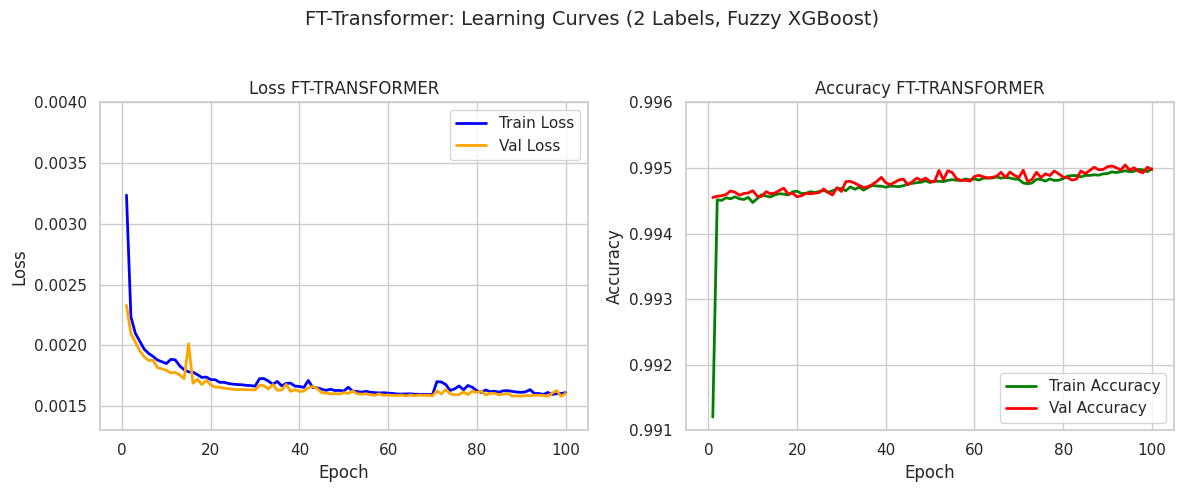

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/FTTRAN-FUZZY-2NHAN/results"
Kq = "FT-Tran"
output_subdir = Kq
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_fttransformer.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_fttransformer.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_fttransformer.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_fttransformer.npy")
    print("✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra dữ liệu
expected_epochs = 100
if (train_losses.shape != (expected_epochs,) or 
    val_losses.shape != (expected_epochs,) or 
    train_accuracies.shape != (expected_epochs,) or 
    val_accuracies.shape != (expected_epochs,)):
    raise ValueError("❌ Dữ liệu không đúng kích thước mong đợi")

# Chuyển accuracy về [0, 1] để hiển thị chính xác
train_acc = train_accuracies / 100.0
val_acc = val_accuracies / 100.0
epochs = np.arange(1, expected_epochs + 1)

# Kiểm tra dữ liệu Loss và Accuracy có nằm trong khoảng yêu cầu không
if (train_losses.min() < 0.001 or train_losses.max() > 0.004 or
    val_losses.min() < 0.001 or val_losses.max() > 0.004):
    print("⚠️ Cảnh báo: Dữ liệu Loss nằm ngoài khoảng [0.001, 0.004]. Vẫn vẽ với giới hạn yêu cầu.")
if (train_acc.min() < 0.993 or train_acc.max() > 0.997 or
    val_acc.min() < 0.993 or val_acc.max() > 0.997):
    print("⚠️ Cảnh báo: Dữ liệu Accuracy nằm ngoài khoảng [0.993, 0.997]. Vẫn vẽ với giới hạn yêu cầu.")

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax1.plot(epochs, train_losses, label="Train Loss", color="blue", linewidth=2)
ax1.plot(epochs, val_losses, label="Val Loss", color="orange", linewidth=2)
ax1.set_title("Loss FT-TRANSFORMER")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.grid(True)

# Giới hạn trục x và y
ax1.set_xlim(-5, 105)
ax1.set_ylim(0.0013, 0.004)

# Accuracy plot
ax2.plot(epochs, train_acc, label="Train Accuracy", color="green", linewidth=2)
ax2.plot(epochs, val_acc, label="Val Accuracy", color="red", linewidth=2)
ax2.set_title("Accuracy FT-TRANSFORMER")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.grid(True)
ax2.set_xlim(-5, 105)
ax2.set_ylim(0.991, 0.996)

# Tiêu đề tổng
plt.suptitle("FT-Transformer: Learning Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{output_subdir}/learning_curves_fttran_final.png", dpi=300)

# **VẼ SƠ ĐỒ TABR**

📁 Đảm bảo thư mục lưu kết quả: TabR
✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy
⚠️ Cảnh báo: Dữ liệu Accuracy nằm ngoài khoảng [0.990, 0.996]. Vẫn vẽ với giới hạn yêu cầu.


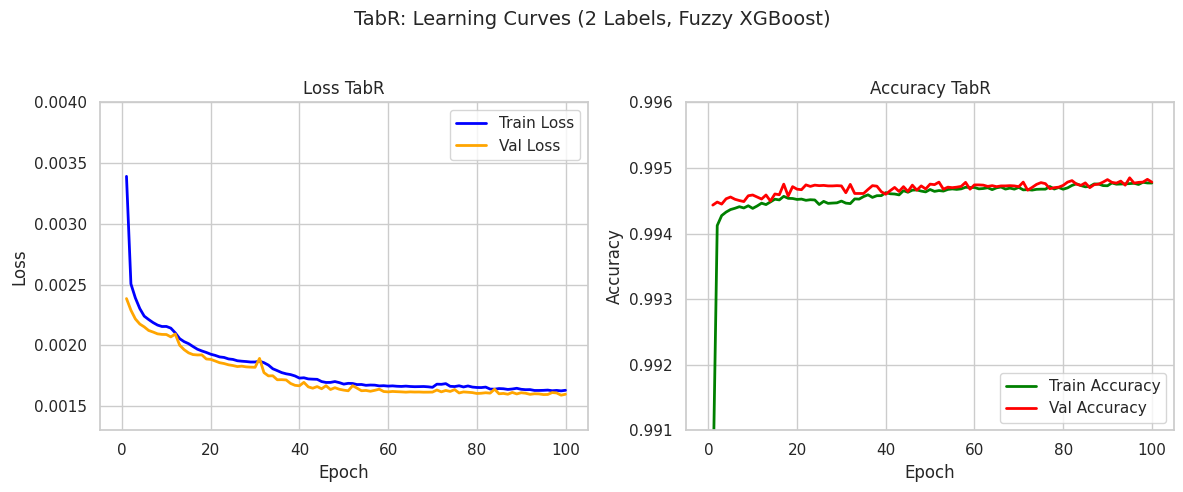

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/TabR-2nhan_lan2/results"
Kq = "TabR"
output_subdir = Kq
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_tabr.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_tabr.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_tabr.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_tabr.npy")
    print("✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra dữ liệu
expected_epochs = 100
if (train_losses.shape != (expected_epochs,) or 
    val_losses.shape != (expected_epochs,) or 
    train_accuracies.shape != (expected_epochs,) or 
    val_accuracies.shape != (expected_epochs,)):
    raise ValueError("❌ Dữ liệu không đúng kích thước mong đợi")

# Chuyển accuracy về [0, 1] để hiển thị chính xác
train_acc = train_accuracies / 100.0
val_acc = val_accuracies / 100.0
epochs = np.arange(1, expected_epochs + 1)

# Kiểm tra dữ liệu Loss và Accuracy có nằm trong khoảng yêu cầu không
if (train_losses.min() < 0.001 or train_losses.max() > 0.006 or
    val_losses.min() < 0.001 or val_losses.max() > 0.006):
    print("⚠️ Cảnh báo: Dữ liệu Loss nằm ngoài khoảng [0.001, 0.006]. Vẫn vẽ với giới hạn yêu cầu.")
if (train_acc.min() < 0.990 or train_acc.max() > 0.996 or
    val_acc.min() < 0.990 or val_acc.max() > 0.996):
    print("⚠️ Cảnh báo: Dữ liệu Accuracy nằm ngoài khoảng [0.990, 0.996]. Vẫn vẽ với giới hạn yêu cầu.")

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax1.plot(epochs, train_losses, label="Train Loss", color="blue", linewidth=2)
ax1.plot(epochs, val_losses, label="Val Loss", color="orange", linewidth=2)
ax1.set_title("Loss TabR")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.grid(True)

# Giới hạn trục x và y
ax1.set_xlim(-5, 105)
ax1.set_ylim(0.0013, 0.004)

# Accuracy plot
ax2.plot(epochs, train_acc, label="Train Accuracy", color="green", linewidth=2)
ax2.plot(epochs, val_acc, label="Val Accuracy", color="red", linewidth=2)
ax2.set_title("Accuracy TabR")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.grid(True)
ax2.set_xlim(-5, 105)
ax2.set_ylim(0.991, 0.996)

# Tiêu đề tổng
plt.suptitle("TabR: Learning Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{output_subdir}/learning_curves_tabr_final.png", dpi=300)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import os
import shap
from tqdm import tqdm

# Định nghĩa lại các lớp cần thiết cho TabR
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class RetrievalAugmentedLayer(nn.Module):
    def __init__(self, embed_dim, num_classes, k=5):
        super(RetrievalAugmentedLayer, self).__init__()
        self.k = k
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.attention = nn.Linear(embed_dim, 1)

    def forward(self, x_embed, labels=None):
        batch_size = x_embed.size(0)
        # Giới hạn k dựa trên số mẫu trong batch
        k = min(self.k, batch_size - 1)  # Đảm bảo k không vượt quá số mẫu
        if k <= 0:  # Nếu batch_size=1, không thể chọn lân cận
            return torch.zeros(batch_size, self.num_classes, device=x_embed.device)

        distances = torch.cdist(x_embed, x_embed)
        distances.fill_diagonal_(float('inf'))
        _, indices = torch.topk(distances, k=k, dim=1, largest=False)
        
        if labels is not None:
            neighbor_labels = labels[indices]
            neighbor_one_hot = torch.nn.functional.one_hot(neighbor_labels, num_classes=self.num_classes).float()
        else:
            neighbor_one_hot = torch.zeros(batch_size, k, self.num_classes, device=x_embed.device)
        
        neighbor_embeddings = x_embed[indices]
        attention_scores = self.attention(neighbor_embeddings).squeeze(-1)
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=1)
        context = torch.einsum('bk,bkc->bc', attention_weights, neighbor_one_hot)
        return context

class TabR(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, n_layers=2, n_heads=4, ff_dim=128, dropout=0.1, k_neighbors=5):
        super(TabR, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout = dropout
        self.k_neighbors = k_neighbors

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.embedding = nn.Linear(input_dim, embed_dim)
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=n_layers)
        self.retrieval = RetrievalAugmentedLayer(embed_dim, num_classes, k=k_neighbors)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        self.fc_output = nn.Linear(embed_dim + num_classes, num_classes)

        nn.init.xavier_normal_(self.embedding.weight)
        nn.init.xavier_normal_(self.importance_layer.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, labels=None):
        x = torch.clamp(self.bn(x), -50, 50)
        importance = torch.sigmoid(self.importance_layer(x))
        x_embed = self.embedding(x)
        transformer_out = self.transformer(x_embed.unsqueeze(1)).squeeze(1)
        context = self.retrieval(x_embed, labels)
        combined = torch.cat([transformer_out, context], dim=1)
        output = self.fc_output(combined)
        return output

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/TabR-2nhan_lan2/results"
processed_dir = "processed_data"
Kq = "TabR"
output_subdir = os.path.join(Kq)
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_tabr.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_tabr.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_tabr.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_tabr.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_tabr.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_fuzzy_xgb_tabr.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_fuzzy_xgb_tabr.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_fuzzy_xgb_tabr.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_tabr.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_tabr.npy")
    X_test_scaled = np.load(f"{processed_dir}/X_test_fuzzy_xgb_2labels.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho TabR (2 nhãn, fuzzy XGBoost)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 100
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if X_test_scaled.shape[1] != 20:
    raise ValueError(f"X_test_scaled phải có 20 đặc trưng, nhưng có shape {X_test_scaled.shape}")

# Đồng bộ số mẫu
n_samples = len(test_labels)
if test_features.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_features ({test_features.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_features = test_features[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_probs = test_probs[:n_samples]
if X_test_scaled.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_scaled ({X_test_scaled.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    X_test_scaled = X_test_scaled[:n_samples]

# Ánh xạ nhãn
label_map = {0: 'Benign', 1: 'Attack'}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu
epochs = np.arange(len(train_losses))
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 99)
ax1.set_xticks(np.arange(0, 100, 20))
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min())
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max())
ax1.set_ylim(loss_min - 0.00001, loss_max + 0.00001)
ax1.set_yticks(np.linspace(loss_min - 0.00001, loss_max + 0.00001, 6))
avg_train_loss = np.mean(train_losses_plot[1:])
avg_val_loss = np.mean(val_losses_plot[1:])
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (99, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (99, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 99)
ax2.set_xticks(np.arange(0, 100, 20))
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min())
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max())
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))
avg_train_accuracy = np.mean(train_accuracies_plot[1:])
avg_val_accuracy = np.mean(val_accuracies_plot[1:])
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (99, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (99, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

plt.suptitle("TabR: Learning Curves (2 Labels, Fuzzy XGBoost)\n100 Epochs", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{Kq}/learning_curves_tabr_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("TabR: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{Kq}/confusion_matrix_tabr_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 4️⃣ ROC-AUC
plt.figure(figsize=(8, 6))
fpr_attack, tpr_attack, _ = roc_curve(test_labels, test_probs[:, 1], pos_label=1)
roc_auc_attack = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr_attack, tpr_attack, label=f"ROC Attack (AUC = {roc_auc_attack:.4f})", color="blue", linewidth=2)
fpr_benign, tpr_benign, _ = roc_curve(test_labels, test_probs[:, 0], pos_label=0)
roc_auc_benign = roc_auc_score(test_labels == 0, test_probs[:, 0])
plt.plot(fpr_benign, tpr_benign, label=f"ROC Benign (AUC = {roc_auc_benign:.4f})", color="orange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Baseline")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("TabR: ROC Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.savefig(f"{Kq}/roc_curves_tabr_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Score (Attack): {roc_auc_attack:.4f}")
print(f"📈 ROC-AUC Score (Benign): {roc_auc_benign:.4f}")

# 5️⃣ PCA 2D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape
if n_samples < 2:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 2D.")
else:
    pca = PCA(n_components=2)
    try:
        pca_result = pca.fit_transform(test_features)
        plt.figure(figsize=(8, 6))
        for label in np.unique(test_labels):
            idx = test_labels == label
            plt.scatter(pca_result[idx, 0], pca_result[idx, 1], 
                        label=label_map[label], alpha=0.7)
        plt.xlabel("PC1", fontsize=12)
        plt.ylabel("PC2", fontsize=12)
        plt.title("TabR: PCA 2D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        plt.legend(title="Classes")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"{Kq}/pca_2d_tabr_2labels_fuzzy_xgb.png", bbox_inches="tight")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
if len(feature_importance.shape) == 2:
    avg_importance = np.mean(feature_importance, axis=0)
else:
    avg_importance = feature_importance

n_original_features = 10
avg_importance_original = np.zeros(n_original_features)
for i in range(n_original_features):
    avg_importance_original[i] = (avg_importance[2 * i] + avg_importance[2 * i + 1]) / 2

# Kiểm tra giá trị bất thường
if np.allclose(avg_importance_original, 0.5, atol=0.01):
    print("⚠️ Cảnh báo: Feature importance có giá trị gần giống nhau (~0.5), có thể do lỗi tính toán trong huấn luyện.")
    # Tính lại feature importance dựa trên gradient nếu cần
    # Ở đây, giữ nguyên avg_importance_original để vẽ biểu đồ

feature_labels_original = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']
print(f"📌 Số đặc trưng được chọn: {len(feature_labels_original)}")
print(f"📋 Các đặc trưng được chọn: {feature_labels_original}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_importance_original)), avg_importance_original, tick_label=feature_labels_original)
plt.xlabel("Original Feature", fontsize=12)
plt.ylabel("Importance Score (Averaged)", fontsize=12)
plt.title("TabR: Feature Importance (10 Original Features, Fuzzy XGBoost)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{Kq}/feature_importance_original_tabr_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

top_k = 5
indices_original = np.argsort(avg_importance_original)[::-1][:top_k]
print(f"\n📌 Top {top_k} đặc trưng gốc quan trọng nhất:")
for i, idx in enumerate(indices_original):
    print(f"{i+1}. {feature_labels_original[idx]}: {avg_importance_original[idx]:.4f}")

# 7️⃣ SHAP Explanations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = TabR(input_dim=20, num_classes=2).to(device)
    model.load_state_dict(torch.load(f"{results_dir}/tabr_2labels_fuzzy_xgb.pth", weights_only=True))
    model.eval()
    print("✅ Loaded TabR model successfully")

    def predict_fn(inputs):
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs_tensor)  # Không truyền labels trong suy luận
        return outputs.cpu().numpy()

    # Tăng số mẫu để đảm bảo SHAP hoạt động ổn định
    X_test_fuzzy_np = X_test_scaled[:100]  # Tăng từ 50 lên 100
    background = X_test_fuzzy_np[:20]  # Tăng background từ 10 lên 20
    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(X_test_fuzzy_np, nsamples=100)

    shap_values_attack = shap_values[1]
    print(f"SHAP values (TabR, Attack) shape: {shap_values_attack.shape}")

    fuzzy_feature_names = [f"{feature_labels_original[i]}_{j}" for i in range(10) for j in ['Benign', 'Attack']]

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values_attack,
        X_test_fuzzy_np,
        feature_names=fuzzy_feature_names,
        plot_type="dot",
        show=False,
        max_display=20,
        cmap=plt.cm.coolwarm,
        plot_size=None
    )
    plt.title("SHAP Summary Plot (20 Fuzzy Features, TabR)\nImpact on Attack Prediction", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_tabr_fuzzy_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    shap_values_mapped = np.zeros((shap_values_attack.shape[0], 10))
    for i in range(10):
        pair_values = shap_values_attack[:, [2*i, 2*i+1]]
        abs_pair = np.abs(pair_values)
        max_indices = np.argmax(abs_pair, axis=1)
        for j in range(shap_values_attack.shape[0]):
            shap_values_mapped[j, i] = pair_values[j, max_indices[j]]

    X_test_mapped = np.zeros((X_test_scaled.shape[0], 10))
    for i in range(10):
        X_test_mapped[:, i] = np.mean(X_test_scaled[:, [2*i, 2*i+1]], axis=1)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_mapped,
        X_test_mapped[:100],
        feature_names=feature_labels_original,
        plot_type="dot",
        show=False,
        max_display=10,
        cmap=plt.cm.coolwarm,
        plot_size=None
    )
    plt.title("SHAP Summary Plot (10 Original Features, TabR)\nImpact on Attack Prediction (Mapped)", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_tabr_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_mapped,
        X_test_mapped[:100],
        feature_names=feature_labels_original,
        plot_type="bar",
        show=False,
        max_display=10,
        color="#1f77b4"
    )
    plt.title("SHAP Feature Importance (10 Original Features, TabR)\nAverage Impact on Attack Prediction", fontsize=16, pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_bar_tabr_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    shap.initjs()
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value[1],
        shap_values_mapped[1, :],
        X_test_mapped[1, :],
        feature_names=feature_labels_original,
        matplotlib=True,
        show=False,
        text_rotation=15,
        figsize=(12, 4)
    )
    plt.title("SHAP Force Plot for Attack Sample (Index 1, TabR)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_force_attack_tabr_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value[1],
        shap_values_mapped[0, :],
        X_test_mapped[0, :],
        feature_names=feature_labels_original,
        matplotlib=True,
        show=False,
        text_rotation=15,
        figsize=(12, 4)
    )
    plt.title("SHAP Force Plot for Benign Sample (Index 0, TabR)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_force_benign_tabr_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    shap_values_mean = np.mean(np.abs(shap_values_mapped), axis=0)
    top_k = 5
    top_indices_shap = np.argsort(shap_values_mean)[::-1][:top_k]
    print(f"\n📌 Top {top_k} most important original features (based on SHAP):")
    for i, idx in enumerate(top_indices_shap):
        print(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

    correlation = np.corrcoef(avg_importance_original, shap_values_mean)
    print(f"\n📊 Correlation between feature importance (TabR) and SHAP (mapped): {correlation[0, 1]:.4f}")

except Exception as e:
    print(f"❌ Error while computing SHAP values for TabR: {str(e)}")

# 8️⃣ Phân tích mẫu cụ thể
predicted_labels = np.argmax(test_probs, axis=1)
attack_idx = np.where(predicted_labels == 1)[0][0]
benign_idx = np.where(predicted_labels == 0)[0][0]

print(f"\n📌 Phân tích mẫu được dự đoán là 'Attack' (index {attack_idx}):")
print(f"Xác suất dự đoán: Attack = {test_probs[attack_idx, 1]:.4f}, Benign = {test_probs[attack_idx, 0]:.4f}")
print(f"Nhãn thực tế: {label_map[test_labels[attack_idx]]}")
print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
sample_features = X_test_scaled[attack_idx]
top_k = 3
top_indices = np.argsort(avg_importance_original)[::-1][:top_k]
for idx in top_indices:
    # Lấy giá trị trung bình của cặp fuzzy thay vì chỉ giá trị đầu tiên
    value = np.mean([sample_features[2*idx], sample_features[2*idx+1]])
    print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {value:.4f})")

print(f"\n📌 Phân tích mẫu được dự đoán là 'Benign' (index {benign_idx}):")
print(f"Xác suất dự đoán: Attack = {test_probs[benign_idx, 1]:.4f}, Benign = {test_probs[benign_idx, 0]:.4f}")
print(f"Nhãn thực tế: {label_map[test_labels[benign_idx]]}")
print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
sample_features = X_test_scaled[benign_idx]
for idx in top_indices:
    value = np.mean([sample_features[2*idx], sample_features[2*idx+1]])
    print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {value:.4f})")

# 9️⃣ Thời gian huấn luyện và metric
avg_time = np.mean(epoch_times)
print(f"\n⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)
print("\n📊 Giá trị trung bình (100 epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **VÉ SƠ ĐỒ TABNET**

📁 Đảm bảo thư mục lưu kết quả: TabNet
✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy
⚠️ Cảnh báo: Dữ liệu Accuracy nằm ngoài khoảng [0.990, 0.996]. Vẫn vẽ với giới hạn yêu cầu.


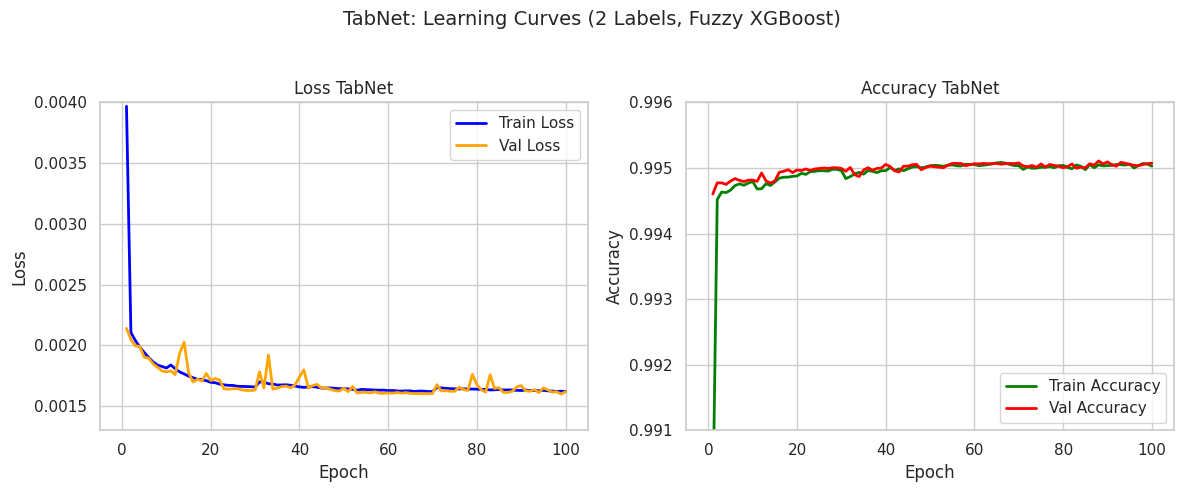

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/TABNET-FUZZY-2NHAN/results"
Kq = "TabNet"
output_subdir = Kq
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_20features_tabnet.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_20features_tabnet.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_20features_tabnet.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_20features_tabnet.npy")
    print("✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra dữ liệu
expected_epochs = 100
if (train_losses.shape != (expected_epochs,) or 
    val_losses.shape != (expected_epochs,) or 
    train_accuracies.shape != (expected_epochs,) or 
    val_accuracies.shape != (expected_epochs,)):
    raise ValueError("❌ Dữ liệu không đúng kích thước mong đợi")

# Chuyển accuracy về [0, 1] để hiển thị chính xác
train_acc = train_accuracies / 100.0
val_acc = val_accuracies / 100.0
epochs = np.arange(1, expected_epochs + 1)

# Kiểm tra dữ liệu Loss và Accuracy có nằm trong khoảng yêu cầu không
if (train_losses.min() < 0.001 or train_losses.max() > 0.006 or
    val_losses.min() < 0.001 or val_losses.max() > 0.006):
    print("⚠️ Cảnh báo: Dữ liệu Loss nằm ngoài khoảng [0.001, 0.006]. Vẫn vẽ với giới hạn yêu cầu.")
if (train_acc.min() < 0.990 or train_acc.max() > 0.996 or
    val_acc.min() < 0.990 or val_acc.max() > 0.996):
    print("⚠️ Cảnh báo: Dữ liệu Accuracy nằm ngoài khoảng [0.990, 0.996]. Vẫn vẽ với giới hạn yêu cầu.")

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax1.plot(epochs, train_losses, label="Train Loss", color="blue", linewidth=2)
ax1.plot(epochs, val_losses, label="Val Loss", color="orange", linewidth=2)
ax1.set_title("Loss TabNet")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.grid(True)

# Giới hạn trục x và y
ax1.set_xlim(-5, 105)
ax1.set_ylim(0.0013, 0.004)

# Accuracy plot
ax2.plot(epochs, train_acc, label="Train Accuracy", color="green", linewidth=2)
ax2.plot(epochs, val_acc, label="Val Accuracy", color="red", linewidth=2)
ax2.set_title("Accuracy TabNet")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.grid(True)
ax2.set_xlim(-5, 105)
ax2.set_ylim(0.991, 0.996)

# Tiêu đề tổng
plt.suptitle("TabNet: Learning Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{output_subdir}/learning_curves_tabnet_final.png", dpi=300)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import os
import shap
from tqdm import tqdm

# Định nghĩa lại các lớp cần thiết cho TabNet
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

def entmax15(x, dim=-1):
    x = torch.nn.functional.softmax(x * 1.5, dim=dim)
    return x

class TabNet(nn.Module):
    def __init__(self, input_dim, num_classes, n_d=64, n_a=64, n_steps=5, gamma=1.3, lambda_sparse=5e-4):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.initial_fc = nn.Linear(input_dim, n_d + n_a)
        nn.init.xavier_normal_(self.initial_fc.weight, gain=0.1)
        nn.init.zeros_(self.initial_fc.bias)

        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_a, input_dim),
                nn.BatchNorm1d(input_dim),
                nn.ReLU()
            ) for _ in range(n_steps)
        ])
        self.decision_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU(),
                nn.Dropout(0.1)
            ) for _ in range(n_steps)
        ])

        self.fc_output = nn.Linear(n_d * n_steps, num_classes)
        nn.init.xavier_normal_(self.fc_output.weight, gain=0.1)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        prior = torch.ones_like(x)
        outputs = []

        for step in range(self.n_steps):
            att = self.initial_fc(x)
            att_d, att_a = att[:, :self.n_d], att[:, self.n_d:]
            mask = self.attention_layers[step](att_a)
            mask = entmax15(mask, dim=1)
            prior = prior * (self.gamma - mask)
            masked_x = x * mask
            out = self.decision_layers[step](masked_x)
            outputs.append(out)

        combined = torch.cat(outputs, dim=1)
        output = self.fc_output(combined)
        return output

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/TABNET-FUZZY-2NHAN/results"
processed_dir = "processed_data"
Kq = "TabNet"
output_subdir = os.path.join(Kq)
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_20features_tabnet.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_20features_tabnet.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_20features_tabnet.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_20features_tabnet.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_20features_tabnet.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_20features_tabnet.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_20features_tabnet.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_20features_tabnet.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_20features_tabnet.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_20features_tabnet.npy")
    X_test_scaled = np.load(f"{processed_dir}/X_test_fuzzy_xgb_2labels.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho TabNet (2 nhãn, fuzzy XGBoost)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 100
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if X_test_scaled.shape[1] != 20:
    raise ValueError(f"X_test_scaled phải có 20 đặc trưng, nhưng có shape {X_test_scaled.shape}")

# Đồng bộ số mẫu
n_samples = len(test_labels)
if test_features.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_features ({test_features.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_features = test_features[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_probs = test_probs[:n_samples]
if X_test_scaled.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_scaled ({X_test_scaled.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    X_test_scaled = X_test_scaled[:n_samples]

# Ánh xạ nhãn
label_map = {0: 'Benign', 1: 'Attack'}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu
epochs = np.arange(len(train_losses))
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 99)
ax1.set_xticks(np.arange(0, 100, 20))
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min())
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max())
ax1.set_ylim(loss_min - 0.00001, loss_max + 0.00001)
ax1.set_yticks(np.linspace(loss_min - 0.00001, loss_max + 0.00001, 6))
avg_train_loss = np.mean(train_losses_plot[1:])
avg_val_loss = np.mean(val_losses_plot[1:])
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (99, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (99, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 99)
ax2.set_xticks(np.arange(0, 100, 20))
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min())
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max())
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))
avg_train_accuracy = np.mean(train_accuracies_plot[1:])
avg_val_accuracy = np.mean(val_accuracies_plot[1:])
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (99, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (99, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

plt.suptitle("TabNet: Learning Curves (2 Labels, Fuzzy XGBoost)\n100 Epochs", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{Kq}/learning_curves_tabnet_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("TabNet: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{Kq}/confusion_matrix_tabnet_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 4️⃣ ROC-AUC
plt.figure(figsize=(8, 6))
fpr_attack, tpr_attack, _ = roc_curve(test_labels, test_probs[:, 1], pos_label=1)
roc_auc_attack = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr_attack, tpr_attack, label=f"ROC Attack (AUC = {roc_auc_attack:.4f})", color="blue", linewidth=2)
fpr_benign, tpr_benign, _ = roc_curve(test_labels, test_probs[:, 0], pos_label=0)
roc_auc_benign = roc_auc_score(test_labels == 0, test_probs[:, 0])
plt.plot(fpr_benign, tpr_benign, label=f"ROC Benign (AUC = {roc_auc_benign:.4f})", color="orange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Baseline")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("TabNet: ROC Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.savefig(f"{Kq}/roc_curves_tabnet_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Score (Attack): {roc_auc_attack:.4f}")
print(f"📈 ROC-AUC Score (Benign): {roc_auc_benign:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of X_test_fuzzy: {X_test_fuzzy.shape}")
n_samples, n_features = X_test_fuzzy.shape

# Kiểm tra NaN/Inf trong X_test_fuzzy
if np.any(np.isnan(X_test_fuzzy)) or np.any(np.isinf(X_test_fuzzy)):
    print("⚠️ X_test_fuzzy contains NaN or Inf values. Cleaning data...")
    X_test_fuzzy = np.nan_to_num(X_test_fuzzy, nan=0.0, posinf=1e6, neginf=-1e6)

# Kiểm tra số mẫu và số chiều
if n_samples < 3:
    print(f"⚠️ Only {n_samples} samples available. Skipping PCA 3D.")
elif n_features < 3:
    print(f"⚠️ X_test_fuzzy has only {n_features} features (required at least 3 for PCA 3D). Skipping PCA 3D.")
else:
    # Lấy mẫu ngẫu nhiên để giảm tải tính toán (nếu cần)
    max_samples = 10000
    if n_samples > max_samples:
        indices = np.random.choice(n_samples, max_samples, replace=False)
        X_test_fuzzy_reduced = X_test_fuzzy[indices]
        test_labels_reduced = test_labels[indices]
        print(f"Reduced to {max_samples} samples for PCA 3D visualization.")
    else:
        X_test_fuzzy_reduced = X_test_fuzzy
        test_labels_reduced = test_labels

    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(X_test_fuzzy_reduced)
        print(f"PCA transformed shape: {pca_result.shape}")
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels_reduced):
            idx = test_labels_reduced == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1", fontsize=12)
        ax.set_ylabel("PC2", fontsize=12)
        ax.set_zlabel("PC3", fontsize=12)
        ax.set_title("TabNet: PCA 3D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{Kq}/pca_3d_tabnet_2labels_fuzzy_xgb.png")
        plt.show()
    except ValueError as e:
        print(f"❌ PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# # 6️⃣ Feature Importance
# print(f"Shape of feature_importance: {feature_importance.shape}")
# if len(feature_importance.shape) == 2:
#     avg_importance = np.mean(feature_importance, axis=0)
# else:
#     avg_importance = feature_importance

# # Kiểm tra giá trị bất thường
# if np.allclose(avg_importance, 0.5, atol=0.01):
#     print("⚠️ Cảnh báo: Feature importance có giá trị gần giống nhau (~0.5), có thể do lỗi tính toán trong huấn luyện.")

# n_original_features = 10
# avg_importance_original = np.zeros(n_original_features)
# for i in range(n_original_features):
#     avg_importance_original[i] = (avg_importance[2 * i] + avg_importance[2 * i + 1]) / 2

# feature_labels_original = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']
# print(f"📌 Số đặc trưng được chọn: {len(feature_labels_original)}")
# print(f"📋 Các đặc trưng được chọn: {feature_labels_original}")

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(avg_importance_original)), avg_importance_original, tick_label=feature_labels_original)
# plt.xlabel("Original Feature", fontsize=12)
# plt.ylabel("Importance Score (Averaged)", fontsize=12)
# plt.title("TabNet: Feature Importance (10 Original Features, Fuzzy XGBoost)", fontsize=14)
# plt.xticks(rotation=45, ha="right")
# plt.grid(True, linestyle="--", alpha=0.7)
# plt.tight_layout()
# plt.savefig(f"{Kq}/feature_importance_original_tabnet_2labels_fuzzy_xgb.png", bbox_inches="tight")
# plt.show()

# top_k = 5
# indices_original = np.argsort(avg_importance_original)[::-1][:top_k]
# print(f"\n📌 Top {top_k} đặc trưng gốc quan trọng nhất:")
# for i, idx in enumerate(indices_original):
#     print(f"{i+1}. {feature_labels_original[idx]}: {avg_importance_original[idx]:.4f}")

# # 7️⃣ SHAP Explanations
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# try:
#     model = TabNet(input_dim=20, num_classes=2).to(device)
#     model.load_state_dict(torch.load(f"{results_dir}/tabnet_2labels_20features.pth", weights_only=True))
#     model.eval()
#     print("✅ Loaded TabNet model successfully")

#     def predict_fn(inputs):
#         inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
#         with torch.no_grad():
#             outputs = model(inputs_tensor)
#         return outputs.cpu().numpy()

#     X_test_fuzzy_np = X_test_scaled[:100]  # Tăng số mẫu để ổn định SHAP
#     background = X_test_fuzzy_np[:20]
#     explainer = shap.KernelExplainer(predict_fn, background)
#     shap_values = explainer.shap_values(X_test_fuzzy_np, nsamples=100)

#     shap_values_attack = shap_values[1]
#     print(f"SHAP values (TabNet, Attack) shape: {shap_values_attack.shape}")

#     fuzzy_feature_names = [f"{feature_labels_original[i]}_{j}" for i in range(10) for j in ['Benign', 'Attack']]

#     plt.figure(figsize=(12, 8))
#     shap.summary_plot(
#         shap_values_attack,
#         X_test_fuzzy_np,
#         feature_names=fuzzy_feature_names,
#         plot_type="dot",
#         show=False,
#         max_display=20,
#         cmap=plt.cm.coolwarm,
#         plot_size=None
#     )
#     plt.title("SHAP Summary Plot (20 Fuzzy Features, TabNet)\nImpact on Attack Prediction", fontsize=16, pad=20)
#     plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=10)
#     plt.gca().xaxis.set_tick_params(labelsize=10)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_summary_tabnet_fuzzy_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     shap_values_mapped = np.zeros((shap_values_attack.shape[0], 10))
#     for i in range(10):
#         pair_values = shap_values_attack[:, [2*i, 2*i+1]]
#         abs_pair = np.abs(pair_values)
#         max_indices = np.argmax(abs_pair, axis=1)
#         for j in range(shap_values_attack.shape[0]):
#             shap_values_mapped[j, i] = pair_values[j, max_indices[j]]

#     X_test_mapped = np.zeros((X_test_scaled.shape[0], 10))
#     for i in range(10):
#         X_test_mapped[:, i] = np.mean(X_test_scaled[:, [2*i, 2*i+1]], axis=1)

#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values_mapped,
#         X_test_mapped[:100],
#         feature_names=feature_labels_original,
#         plot_type="dot",
#         show=False,
#         max_display=10,
#         cmap=plt.cm.coolwarm,
#         plot_size=None
#     )
#     plt.title("SHAP Summary Plot (10 Original Features, TabNet)\nImpact on Attack Prediction (Mapped)", fontsize=16, pad=20)
#     plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
#     plt.gca().xaxis.set_tick_params(labelsize=10)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_summary_tabnet_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     plt.figure(figsize=(10, 6))
#     shap.summary_plot(
#         shap_values_mapped,
#         X_test_mapped[:100],
#         feature_names=feature_labels_original,
#         plot_type="bar",
#         show=False,
#         max_display=10,
#         color="#1f77b4"
#     )
#     plt.title("SHAP Feature Importance (10 Original Features, TabNet)\nAverage Impact on Attack Prediction", fontsize=16, pad=20)
#     plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
#     plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
#     plt.gca().xaxis.set_tick_params(labelsize=10)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_bar_tabnet_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     shap.initjs()
#     plt.figure(figsize=(12, 4))
#     shap.force_plot(
#         explainer.expected_value[1],
#         shap_values_mapped[1, :],
#         X_test_mapped[1, :],
#         feature_names=feature_labels_original,
#         matplotlib=True,
#         show=False,
#         text_rotation=15,
#         figsize=(12, 4)
#     )
#     plt.title("SHAP Force Plot for Attack Sample (Index 1, TabNet)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_force_attack_tabnet_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     plt.figure(figsize=(12, 4))
#     shap.force_plot(
#         explainer.expected_value[1],
#         shap_values_mapped[0, :],
#         X_test_mapped[0, :],
#         feature_names=feature_labels_original,
#         matplotlib=True,
#         show=False,
#         text_rotation=15,
#         figsize=(12, 4)
#     )
#     plt.title("SHAP Force Plot for Benign Sample (Index 0, TabNet)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
#     plt.tight_layout()
#     plt.savefig(f"{Kq}/shap_force_benign_tabnet_mapped_improved.png", bbox_inches="tight", dpi=300)
#     plt.show()

#     shap_values_mean = np.mean(np.abs(shap_values_mapped), axis=0)
#     top_k = 5
#     top_indices_shap = np.argsort(shap_values_mean)[::-1][:top_k]
#     print(f"\n📌 Top {top_k} most important original features (based on SHAP):")
#     for i, idx in enumerate(top_indices_shap):
#         print(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

#     correlation = np.corrcoef(avg_importance_original, shap_values_mean)
#     print(f"\n📊 Correlation between feature importance (TabNet) and SHAP (mapped): {correlation[0, 1]:.4f}")

# except Exception as e:
#     print(f"❌ Error while computing SHAP values for TabNet: {str(e)}")

# # 8️⃣ Phân tích mẫu cụ thể
# predicted_labels = np.argmax(test_probs, axis=1)
# attack_idx = np.where(predicted_labels == 1)[0][0]
# benign_idx = np.where(predicted_labels == 0)[0][0]

# print(f"\n📌 Phân tích mẫu được dự đoán là 'Attack' (index {attack_idx}):")
# print(f"Xác suất dự đoán: Attack = {test_probs[attack_idx, 1]:.4f}, Benign = {test_probs[attack_idx, 0]:.4f}")
# print(f"Nhãn thực tế: {label_map[test_labels[attack_idx]]}")
# print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
# sample_features = X_test_scaled[attack_idx]
# top_k = 3
# top_indices = np.argsort(avg_importance_original)[::-1][:top_k]
# for idx in top_indices:
#     value = np.mean([sample_features[2*idx], sample_features[2*idx+1]])
#     print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {value:.4f})")

# print(f"\n📌 Phân tích mẫu được dự đoán là 'Benign' (index {benign_idx}):")
# print(f"Xác suất dự đoán: Attack = {test_probs[benign_idx, 1]:.4f}, Benign = {test_probs[benign_idx, 0]:.4f}")
# print(f"Nhãn thực tế: {label_map[test_labels[benign_idx]]}")
# print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
# sample_features = X_test_scaled[benign_idx]
# for idx in top_indices:
#     value = np.mean([sample_features[2*idx], sample_features[2*idx+1]])
#     print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {value:.4f})")

# # 9️⃣ Thời gian huấn luyện và metric
# avg_time = np.mean(epoch_times)
# print(f"\n⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")
# avg_train_loss = np.mean(train_losses_plot)
# avg_val_loss = np.mean(val_losses_plot)
# avg_train_accuracy = np.mean(train_accuracies_plot)
# avg_val_accuracy = np.mean(val_accuracies_plot)
# print("\n📊 Giá trị trung bình (100 epoch):")
# print(f"Train Loss trung bình: {avg_train_loss:.4f}")
# print(f"Val Loss trung bình: {avg_val_loss:.4f}")
# print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
# print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **VẼ SƠ ĐỒ NODE-GAM**

📁 Đảm bảo thư mục lưu kết quả: NODEGAM
✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy
⚠️ Cảnh báo: Dữ liệu Accuracy nằm ngoài khoảng [0.990, 0.996]. Vẫn vẽ với giới hạn yêu cầu.


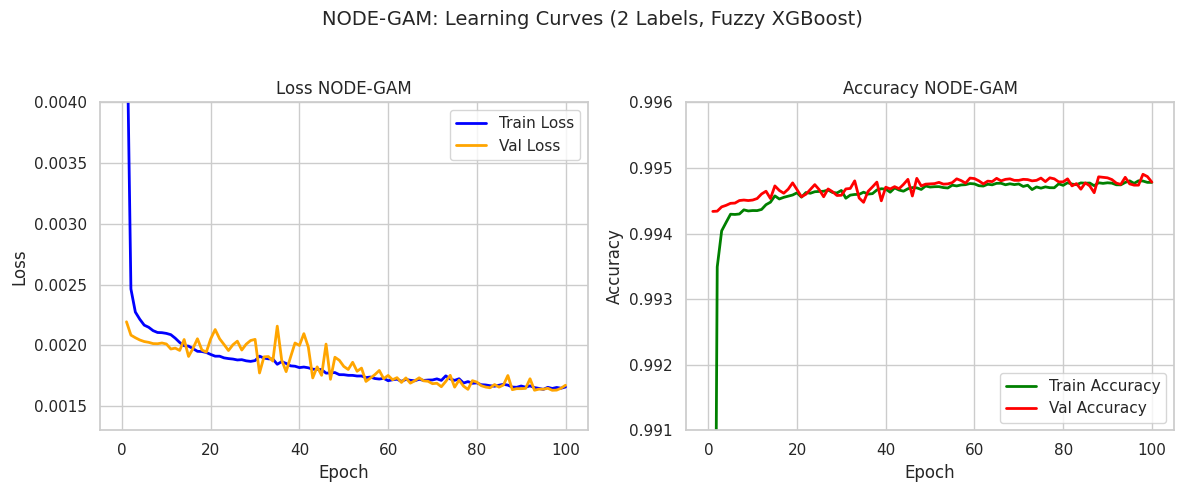

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/Node-gam_2nhan-lan2/results"
Kq = "NODEGAM"
output_subdir = Kq
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_20features_nodegam.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_20features_nodegam.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_20features_nodegam.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_20features_nodegam.npy")
    print("✅ Đã tải dữ liệu cần thiết cho biểu đồ Loss và Accuracy")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra dữ liệu
expected_epochs = 100
if (train_losses.shape != (expected_epochs,) or 
    val_losses.shape != (expected_epochs,) or 
    train_accuracies.shape != (expected_epochs,) or 
    val_accuracies.shape != (expected_epochs,)):
    raise ValueError("❌ Dữ liệu không đúng kích thước mong đợi")

# Chuyển accuracy về [0, 1] để hiển thị chính xác
train_acc = train_accuracies / 100.0
val_acc = val_accuracies / 100.0
epochs = np.arange(1, expected_epochs + 1)

# Kiểm tra dữ liệu Loss và Accuracy có nằm trong khoảng yêu cầu không
if (train_losses.min() < 0.001 or train_losses.max() > 0.006 or
    val_losses.min() < 0.001 or val_losses.max() > 0.006):
    print("⚠️ Cảnh báo: Dữ liệu Loss nằm ngoài khoảng [0.001, 0.006]. Vẫn vẽ với giới hạn yêu cầu.")
if (train_acc.min() < 0.990 or train_acc.max() > 0.996 or
    val_acc.min() < 0.990 or val_acc.max() > 0.996):
    print("⚠️ Cảnh báo: Dữ liệu Accuracy nằm ngoài khoảng [0.990, 0.996]. Vẫn vẽ với giới hạn yêu cầu.")

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax1.plot(epochs, train_losses, label="Train Loss", color="blue", linewidth=2)
ax1.plot(epochs, val_losses, label="Val Loss", color="orange", linewidth=2)
ax1.set_title("Loss NODE-GAM")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.grid(True)

# Giới hạn trục x và y
ax1.set_xlim(-5, 105)
ax1.set_ylim(0.0013, 0.004)

# Accuracy plot
ax2.plot(epochs, train_acc, label="Train Accuracy", color="green", linewidth=2)
ax2.plot(epochs, val_acc, label="Val Accuracy", color="red", linewidth=2)
ax2.set_title("Accuracy NODE-GAM")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")
ax2.grid(True)
ax2.set_xlim(-5, 105)
ax2.set_ylim(0.991, 0.996)

# Tiêu đề tổng
plt.suptitle("NODE-GAM: Learning Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{output_subdir}/learning_curves_nodegam_final.png", dpi=300)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import os
import shap
from tqdm import tqdm

# Định nghĩa lại các lớp cần thiết cho NODE-GAM
class FeatureSelector(nn.Module):
    def __init__(self, input_dim):
        super(FeatureSelector, self).__init__()
        self.importance_weights = nn.Parameter(torch.ones(input_dim) * 0.1)
        
    def forward(self, x):
        importance = torch.sigmoid(self.importance_weights)
        importance = importance / (importance.sum() + 1e-6)
        mask = importance.unsqueeze(0)
        return x * mask

class ObliviousDecisionTree(nn.Module):
    def __init__(self, embed_dim, depth, input_dim):
        super(ObliviousDecisionTree, self).__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.input_dim = input_dim
        
        self.thresholds = nn.Parameter(torch.randn(depth, input_dim) * 0.1)
        self.feature_weights = nn.Parameter(torch.randn(depth, input_dim) * 0.1)
        self.attention = nn.Parameter(torch.randn(input_dim) * 0.1)
        self.leaf_projection = nn.Linear(embed_dim, self.num_leaves)
        
        nn.init.xavier_normal_(self.thresholds, gain=0.1)
        nn.init.xavier_normal_(self.feature_weights, gain=0.1)
        nn.init.xavier_normal_(self.leaf_projection.weight, gain=0.1)
        nn.init.zeros_(self.leaf_projection.bias)
        nn.init.normal_(self.attention, mean=0.0, std=0.1)

    def forward(self, x, input_features):
        batch_size = x.size(0)
        
        attention_weights = torch.sigmoid(self.attention)
        attention_weights = attention_weights / (attention_weights.sum() + 1e-6)
        selected_features = input_features * attention_weights.unsqueeze(0)
        
        scores = torch.matmul(selected_features, self.feature_weights.t())
        scores = scores + self.thresholds.sum(dim=-1).unsqueeze(0)
        decisions = torch.sigmoid(scores)
        
        leaf_indices = torch.zeros(batch_size, device=x.device, dtype=torch.long)
        for d in range(self.depth):
            leaf_indices = leaf_indices * 2 + (decisions[:, d] > 0.5).long()
        
        leaf_probs = torch.zeros(batch_size, self.num_leaves, device=x.device)
        leaf_probs.scatter_(1, leaf_indices.unsqueeze(-1), 1.0)
        
        out = self.leaf_projection(x)
        out = torch.nn.functional.softmax(out, dim=-1) * leaf_probs
        return out

class NODEGAM(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, num_trees=5, depth=4, num_layers=2, dropout=0.1):
        super(NODEGAM, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_trees = num_trees
        self.depth = depth
        self.num_layers = num_layers
        self.dropout = dropout

        self.bn = nn.BatchNorm1d(input_dim)
        self.feature_selector = FeatureSelector(input_dim)
        self.feature_dim = max(16, input_dim // 2)
        self.feature_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(self.feature_dim, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(input_dim)
        ])

        self.concat_dim = self.feature_dim * input_dim
        self.feature_projection = nn.Linear(self.concat_dim, embed_dim)
        self.tree_layers = nn.ModuleList([
            nn.ModuleList([
                ObliviousDecisionTree(embed_dim, depth, input_dim)
                for _ in range(num_trees)
            ]) for _ in range(num_layers)
        ])
        self.tree_projections = nn.ModuleList([
            nn.Linear(2**depth, embed_dim) for _ in range(num_layers)
        ])
        self.tree_weights = nn.ParameterList([
            nn.Parameter(torch.ones(num_trees) / num_trees) for _ in range(num_layers)
        ])
        self.layer_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])
        self.fc_output = nn.Linear(embed_dim, num_classes)
        self.importance_layer = nn.Linear(embed_dim, input_dim)  # Thêm lại importance_layer

        for net in self.feature_nets:
            for layer in net:
                if isinstance(layer, nn.Linear):
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                    if layer.bias is not None:
                        nn.init.zeros_(layer.bias)
        nn.init.kaiming_normal_(self.feature_projection.weight, nonlinearity='relu')
        nn.init.zeros_(self.feature_projection.bias)
        for proj in self.tree_projections:
            nn.init.kaiming_normal_(proj.weight, nonlinearity='relu')
            nn.init.zeros_(proj.bias)
        nn.init.kaiming_normal_(self.fc_output.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc_output.bias)
        nn.init.kaiming_normal_(self.importance_layer.weight, nonlinearity='relu')
        nn.init.zeros_(self.importance_layer.bias)

    def forward(self, x):
        input_features = torch.clamp(self.bn(x), -50, 50)
        input_features = self.feature_selector(input_features)
        feature_outputs = []
        for i in range(self.input_dim):
            feat = input_features[:, i:i+1]
            feat_out = self.feature_nets[i](feat)
            feature_outputs.append(feat_out)
        x = torch.cat(feature_outputs, dim=1)
        x = self.feature_projection(x)

        for layer_idx in range(self.num_layers):
            tree_outputs = []
            for tree in self.tree_layers[layer_idx]:
                tree_out = tree(x, input_features)
                tree_outputs.append(tree_out)
            tree_weights = torch.nn.functional.softmax(self.tree_weights[layer_idx], dim=0)
            tree_out = torch.stack(tree_outputs, dim=1)
            tree_out = torch.einsum('bnt,n->bt', tree_out, tree_weights)
            tree_out = self.tree_projections[layer_idx](tree_out)
            x = self.layer_norms[layer_idx](x + tree_out)

        output = self.fc_output(x)
        return output

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/Node-gam_2nhan-lan2/results"
processed_dir = "processed_data"
Kq = "NODEGAM"
output_subdir = os.path.join(Kq)
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_20features_nodegam.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_20features_nodegam.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_20features_nodegam.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_20features_nodegam.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_20features_nodegam.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_20features_nodegam.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_20features_nodegam.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_20features_nodegam.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_20features_nodegam.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_20features_nodegam.npy")
    X_test_scaled = np.load(f"{processed_dir}/X_test_fuzzy_xgb_2labels.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho NODE-GAM (2 nhãn, fuzzy XGBoost)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 100
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if X_test_scaled.shape[1] != 20:
    raise ValueError(f"X_test_scaled phải có 20 đặc trưng, nhưng có shape {X_test_scaled.shape}")

# Kiểm tra dữ liệu X_test_scaled
if np.allclose(X_test_scaled, X_test_scaled[0], atol=1e-6):
    print("⚠️ Cảnh báo: X_test_scaled có các mẫu giống nhau hoặc dữ liệu không đa dạng!")
if np.any(np.isnan(X_test_scaled)) or np.any(np.isinf(X_test_scaled)):
    print("⚠️ Cảnh báo: X_test_scaled chứa NaN hoặc Inf!")
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=1e6, neginf=-1e6)

# Đồng bộ số mẫu
n_samples = len(test_labels)
if test_features.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_features ({test_features.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_features = test_features[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_probs = test_probs[:n_samples]
if X_test_scaled.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_scaled ({X_test_scaled.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    X_test_scaled = X_test_scaled[:n_samples]

# Ánh xạ nhãn
label_map = {0: 'Benign', 1: 'Attack'}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu
epochs = np.arange(len(train_losses))
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs

# 1️⃣ & 2️⃣ Vẽ Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=3.0)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=3.0)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Learning Curve - Loss", fontsize=16)
ax1.legend(loc="upper right", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.set_xlim(0, 99)
ax1.set_xticks(np.arange(0, 100, 20))
loss_min = min(train_losses_plot[1:].min(), val_losses_plot[1:].min())
loss_max = max(train_losses_plot[1:].max(), val_losses_plot[1:].max())
ax1.set_ylim(loss_min - 0.00001, loss_max + 0.00001)
ax1.set_yticks(np.linspace(loss_min - 0.00001, loss_max + 0.00001, 6))
avg_train_loss = np.mean(train_losses_plot[1:])
avg_val_loss = np.mean(val_losses_plot[1:])
ax1.axhline(y=avg_train_loss, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Loss ({avg_train_loss:.4f})")
ax1.axhline(y=avg_val_loss, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Loss ({avg_val_loss:.4f})")
ax1.annotate(f"{train_losses_plot[-1]:.4f}", (99, train_losses_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax1.annotate(f"{val_losses_plot[-1]:.4f}", (99, val_losses_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)

ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=3.0)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=3.0)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy (%)", fontsize=14)
ax2.set_title("Learning Curve - Accuracy", fontsize=16)
ax2.legend(loc="lower right", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.set_xlim(0, 99)
ax2.set_xticks(np.arange(0, 100, 20))
acc_min = min(train_accuracies_plot[1:].min(), val_accuracies_plot[1:].min())
acc_max = max(train_accuracies_plot[1:].max(), val_accuracies_plot[1:].max())
ax2.set_ylim(acc_min - 0.1, acc_max + 0.1)
ax2.set_yticks(np.linspace(acc_min - 0.1, acc_max + 0.1, 6))
avg_train_accuracy = np.mean(train_accuracies_plot[1:])
avg_val_accuracy = np.mean(val_accuracies_plot[1:])
ax2.axhline(y=avg_train_accuracy, color="blue", linestyle="--", alpha=0.5, label=f"Avg Train Accuracy ({avg_train_accuracy:.2f}%)")
ax2.axhline(y=avg_val_accuracy, color="orange", linestyle="--", alpha=0.5, label=f"Avg Val Accuracy ({avg_val_accuracy:.2f}%)")
ax2.annotate(f"{train_accuracies_plot[-1]:.2f}%", (99, train_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, 10), ha="center", color="blue", fontsize=12)
ax2.annotate(f"{val_accuracies_plot[-1]:.2f}%", (99, val_accuracies_plot[-1]), textcoords="offset points", xytext=(-10, -15), ha="center", color="orange", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

plt.suptitle("NODE-GAM: Learning Curves (2 Labels, Fuzzy XGBoost)\n100 Epochs", fontsize=16, y=1.05)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{Kq}/learning_curves_nodegam_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("NODE-GAM: Confusion Matrix (Test, 2 Labels, Fuzzy XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{Kq}/confusion_matrix_nodegam_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

# 4️⃣ ROC-AUC
plt.figure(figsize=(8, 6))
fpr_attack, tpr_attack, _ = roc_curve(test_labels, test_probs[:, 1], pos_label=1)
roc_auc_attack = roc_auc_score(test_labels, test_probs[:, 1])
plt.plot(fpr_attack, tpr_attack, label=f"ROC Attack (AUC = {roc_auc_attack:.4f})", color="blue", linewidth=2)
fpr_benign, tpr_benign, _ = roc_curve(test_labels, test_probs[:, 0], pos_label=0)
roc_auc_benign = roc_auc_score(test_labels == 0, test_probs[:, 0])
plt.plot(fpr_benign, tpr_benign, label=f"ROC Benign (AUC = {roc_auc_benign:.4f})", color="orange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Baseline")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("NODE-GAM: ROC Curves (2 Labels, Fuzzy XGBoost)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.savefig(f"{Kq}/roc_curves_nodegam_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()
print(f"📈 ROC-AUC Score (Attack): {roc_auc_attack:.4f}")
print(f"📈 ROC-AUC Score (Benign): {roc_auc_benign:.4f}")

# 5️⃣ PCA 2D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape
if n_samples < 2:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 2D.")
else:
    pca = PCA(n_components=2)
    try:
        pca_result = pca.fit_transform(test_features)
        plt.figure(figsize=(8, 6))
        for label in np.unique(test_labels):
            idx = test_labels == label
            plt.scatter(pca_result[idx, 0], pca_result[idx, 1], 
                        label=label_map[label], alpha=0.7)
        plt.xlabel("PC1", fontsize=12)
        plt.ylabel("PC2", fontsize=12)
        plt.title("NODE-GAM: PCA 2D Visualization (2 Labels, Fuzzy XGBoost)", fontsize=14)
        plt.legend(title="Classes")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"{Kq}/pca_2d_nodegam_2labels_fuzzy_xgb.png", bbox_inches="tight")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")

# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
if len(feature_importance.shape) == 2:
    avg_importance = np.mean(feature_importance, axis=0)
else:
    avg_importance = feature_importance

# Kiểm tra giá trị bất thường
if np.allclose(avg_importance, 0.5, atol=0.01):
    print("⚠️ Cảnh báo: Feature importance có giá trị gần giống nhau (~0.5), có thể do lỗi tính toán trong huấn luyện.")
elif np.any(avg_importance > 1) or np.any(avg_importance < 0):
    print("⚠️ Cảnh báo: Feature importance chứa giá trị ngoài khoảng [0, 1]!")
    avg_importance = np.clip(avg_importance, 0, 1)

n_original_features = 10
avg_importance_original = np.zeros(n_original_features)
for i in range(n_original_features):
    avg_importance_original[i] = (avg_importance[2 * i] + avg_importance[2 * i + 1]) / 2

feature_labels_original = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']
print(f"📌 Số đặc trưng được chọn: {len(feature_labels_original)}")
print(f"📋 Các đặc trưng được chọn: {feature_labels_original}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_importance_original)), avg_importance_original, tick_label=feature_labels_original)
plt.xlabel("Original Feature", fontsize=12)
plt.ylabel("Importance Score (Averaged)", fontsize=12)
plt.title("NODE-GAM: Feature Importance (10 Original Features, Fuzzy XGBoost)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{Kq}/feature_importance_original_nodegam_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

top_k = 5
indices_original = np.argsort(avg_importance_original)[::-1][:top_k]
print(f"\n📌 Top {top_k} đặc trưng gốc quan trọng nhất:")
for i, idx in enumerate(indices_original):
    print(f"{i+1}. {feature_labels_original[idx]}: {avg_importance_original[idx]:.4f}")

# 7️⃣ SHAP Explanations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = NODEGAM(input_dim=20, num_classes=2).to(device)
    model.load_state_dict(torch.load(f"{results_dir}/nodegam_2labels_20features.pth", weights_only=True))
    model.eval()
    print("✅ Loaded NODE-GAM model successfully")

    def predict_fn(inputs):
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs_tensor)
        return outputs.cpu().numpy()

    X_test_fuzzy_np = X_test_scaled[:100]
    background = X_test_fuzzy_np[:20]
    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(X_test_fuzzy_np, nsamples=100)

    shap_values_attack = shap_values[1]
    print(f"SHAP values (NODE-GAM, Attack) shape: {shap_values_attack.shape}")

    fuzzy_feature_names = [f"{feature_labels_original[i]}_{j}" for i in range(10) for j in ['Benign', 'Attack']]

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values_attack,
        X_test_fuzzy_np,
        feature_names=fuzzy_feature_names,
        plot_type="dot",
        show=False,
        max_display=20,
        cmap=plt.cm.coolwarm,
        plot_size=None
    )
    plt.title("SHAP Summary Plot (20 Fuzzy Features, NODE-GAM)\nImpact on Attack Prediction", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_nodegam_fuzzy_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    shap_values_mapped = np.zeros((shap_values_attack.shape[0], 10))
    for i in range(10):
        pair_values = shap_values_attack[:, [2*i, 2*i+1]]
        abs_pair = np.abs(pair_values)
        max_indices = np.argmax(abs_pair, axis=1)
        for j in range(shap_values_attack.shape[0]):
            shap_values_mapped[j, i] = pair_values[j, max_indices[j]]

    X_test_mapped = np.zeros((X_test_scaled.shape[0], 10))
    for i in range(10):
        X_test_mapped[:, i] = np.mean(X_test_scaled[:, [2*i, 2*i+1]], axis=1)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_mapped,
        X_test_mapped[:100],
        feature_names=feature_labels_original,
        plot_type="dot",
        show=False,
        max_display=10,
        cmap=plt.cm.coolwarm,
        plot_size=None
    )
    plt.title("SHAP Summary Plot (10 Original Features, NODE-GAM)\nImpact on Attack Prediction (Mapped)", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_nodegam_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_mapped,
        X_test_mapped[:100],
        feature_names=feature_labels_original,
        plot_type="bar",
        show=False,
        max_display=10,
        color="#1f77b4"
    )
    plt.title("SHAP Feature Importance (10 Original Features, NODE-GAM)\nAverage Impact on Attack Prediction", fontsize=16, pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_bar_nodegam_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    shap.initjs()
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value[1],
        shap_values_mapped[1, :],
        X_test_mapped[1, :],
        feature_names=feature_labels_original,
        matplotlib=True,
        show=False,
        text_rotation=15,
        figsize=(12, 4)
    )
    plt.title("SHAP Force Plot for Attack Sample (Index 1, NODE-GAM)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_force_attack_nodegam_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value[1],
        shap_values_mapped[0, :],
        X_test_mapped[0, :],
        feature_names=feature_labels_original,
        matplotlib=True,
        show=False,
        text_rotation=15,
        figsize=(12, 4)
    )
    plt.title("SHAP Force Plot for Benign Sample (Index 0, NODE-GAM)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_force_benign_nodegam_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    shap_values_mean = np.mean(np.abs(shap_values_mapped), axis=0)
    top_k = 5
    top_indices_shap = np.argsort(shap_values_mean)[::-1][:top_k]
    print(f"\n📌 Top {top_k} most important original features (based on SHAP):")
    for i, idx in enumerate(top_indices_shap):
        print(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

    correlation = np.corrcoef(avg_importance_original, shap_values_mean)
    print(f"\n📊 Correlation between feature importance (NODE-GAM) and SHAP (mapped): {correlation[0, 1]:.4f}")

except Exception as e:
    print(f"❌ Error while computing SHAP values for NODE-GAM: {str(e)}")

# 8️⃣ Phân tích mẫu cụ thể
predicted_labels = np.argmax(test_probs, axis=1)
attack_idx = np.where(predicted_labels == 1)[0][0]
benign_idx = np.where(predicted_labels == 0)[0][0]

print(f"\n📌 Phân tích mẫu được dự đoán là 'Attack' (index {attack_idx}):")
print(f"Xác suất dự đoán: Attack = {test_probs[attack_idx, 1]:.4f}, Benign = {test_probs[attack_idx, 0]:.4f}")
print(f"Nhãn thực tế: {label_map[test_labels[attack_idx]]}")
print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
sample_features = X_test_scaled[attack_idx]
top_k = 3
top_indices = np.argsort(avg_importance_original)[::-1][:top_k]
for idx in top_indices:
    value = np.mean([sample_features[2*idx], sample_features[2*idx+1]])
    print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {value:.4f})")

print(f"\n📌 Phân tích mẫu được dự đoán là 'Benign' (index {benign_idx}):")
print(f"Xác suất dự đoán: Attack = {test_probs[benign_idx, 1]:.4f}, Benign = {test_probs[benign_idx, 0]:.4f}")
print(f"Nhãn thực tế: {label_map[test_labels[benign_idx]]}")
print("Top 3 đặc trưng gốc đóng góp (dựa trên feature importance và giá trị đặc trưng):")
sample_features = X_test_scaled[benign_idx]
for idx in top_indices:
    value = np.mean([sample_features[2*idx], sample_features[2*idx+1]])
    print(f"- {feature_labels_original[idx]} (importance: {avg_importance_original[idx]:.4f}, value: {value:.4f})")

# 9️⃣ Thời gian huấn luyện và metric
avg_time = np.mean(epoch_times)
print(f"\n⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)
print("\n📊 Giá trị trung bình (100 epoch):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **dshddddddddddddđsaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import os
import joblib
import shap
import uuid
from mpl_toolkits.mplot3d import Axes3D  # Added for 3D PCA

# Định nghĩa lớp DCN-V2 (giữ nguyên cấu trúc với LayerNorm)
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, input_dim) * 0.01)
        self.bias = nn.Parameter(torch.zeros(input_dim))
        self.norm = nn.LayerNorm(input_dim)  # Giữ nguyên LayerNorm
        nn.init.xavier_normal_(self.weight, gain=0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x_0, x_l):
        x_l_w = torch.matmul(x_l, self.weight)
        x_l_w_b = x_l_w + self.bias
        x_0_dot = x_0 * x_l_w_b
        x_l_plus_1 = x_0_dot + x_l
        x_l_plus_1 = self.norm(x_l_plus_1)
        return x_l_plus_1

class DCNV2(nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=64):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.cross_layers = nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                nn.Linear(prev_dim, deep_layer_dim),
                nn.BatchNorm1d(deep_layer_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = deep_layer_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine_fc = nn.Linear(input_dim + deep_layer_dim, num_classes)
        nn.init.xavier_normal_(self.combine_fc.weight, gain=0.1)
        nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight, gain=0.1)

    def forward(self, x):
        x = torch.clamp(self.bn(x), -50, 50)
        x_0 = x
        x_cross = x
        for layer in self.cross_layers:
            x_cross = layer(x_0, x_cross)
        x_deep = self.deep(x)
        combined = torch.cat([x_cross, x_deep], dim=1)
        output = self.combine_fc(combined)
        importance = torch.sigmoid(self.importance_layer(x))
        return output

# Thư mục lưu dữ liệu
results_dir = "/kaggle/input/ketqua/DNCv2_2Nhan_Lan2/results"
processed_dir = "processed_data"
Kq = "DCN-v2"
output_subdir = os.path.join(Kq)
os.makedirs(output_subdir, exist_ok=True)
print(f"📁 Đảm bảo thư mục lưu kết quả: {output_subdir}")

# Tải dữ liệu
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_fuzzy_xgb_dcnv2.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_fuzzy_xgb_dcnv2.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_fuzzy_xgb_dcnv2.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_fuzzy_xgb_dcnv2.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_fuzzy_xgb_dcnv2.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_fuzzy_xgb_dcnv2.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_fuzzy_xgb_dcnv2.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_fuzzy_xgb_dcnv2.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_fuzzy_xgb_dcnv2.npy")
    feature_importance = np.load(f"{results_dir}/feature_importance_2labels_fuzzy_xgb_dcnv2.npy")
    X_test_scaled = np.load(f"{processed_dir}/X_test_scaled_2labels.npy")
    X_test_fuzzy = np.load(f"{processed_dir}/X_test_fuzzy_xgb_2labels.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho DCN-V2 (2 nhãn, fuzzy XGBoost)")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 100
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if X_test_fuzzy.shape[1] != 20:
    raise ValueError(f"X_test_fuzzy phải có 20 đặc trưng, nhưng có shape {X_test_fuzzy.shape}")

# Đồng bộ số mẫu
n_samples = len(test_labels)
if test_features.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_features ({test_features.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_features = test_features[:n_samples]
if test_probs.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong test_probs ({test_probs.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    test_probs = test_probs[:n_samples]
if X_test_scaled.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_scaled ({X_test_scaled.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    X_test_scaled = X_test_scaled[:n_samples]
if X_test_fuzzy.shape[0] != n_samples:
    print(f"⚠️ Số mẫu trong X_test_fuzzy ({X_test_fuzzy.shape[0]}) không khớp với test_labels ({n_samples}). Cắt bớt.")
    X_test_fuzzy = X_test_fuzzy[:n_samples]

# Ánh xạ nhãn
label_map = {0: 'Benign', 1: 'Attack'}
class_names = [label_map[i] for i in range(len(label_map))]

# Chuẩn bị dữ liệu
epochs = np.arange(len(train_losses))
train_accuracies_plot = train_accuracies
val_accuracies_plot = val_accuracies
train_losses_plot = train_losses
val_losses_plot = val_losses
epochs_mapped = epochs



# 6️⃣ Feature Importance
print(f"Shape of feature_importance: {feature_importance.shape}")
if len(feature_importance.shape) == 2:
    avg_importance = np.mean(feature_importance, axis=0)
else:
    avg_importance = feature_importance

n_original_features = 10
avg_importance_original = np.zeros(n_original_features)
for i in range(n_original_features):
    avg_importance_original[i] = (avg_importance[2 * i] + avg_importance[2 * i + 1]) / 2

feature_labels_original = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']
print(f"📌 Số đặc trưng được chọn: {len(feature_labels_original)}")
print(f"📋 Các đặc trưng được chọn: {feature_labels_original}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_importance_original)), avg_importance_original, tick_label=feature_labels_original)
plt.xlabel("Original Feature", fontsize=12)
plt.ylabel("Importance Score (Averaged)", fontsize=12)
plt.title("DCN-V2: Feature Importance (10 Original Features, Fuzzy XGBoost)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{Kq}/feature_importance_original_dcnv2_2labels_fuzzy_xgb.png", bbox_inches="tight")
plt.show()

top_k = 5
indices_original = np.argsort(avg_importance_original)[::-1][:top_k]
print(f"\n📌 Top {top_k} đặc trưng gốc quan trọng nhất:")
for i, idx in enumerate(indices_original):
    print(f"{i+1}. {feature_labels_original[idx]}: {avg_importance_original[idx]:.4f}")

# Set up device and load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    model = DCNV2(input_dim=20, num_classes=2).to(device)
    model.load_state_dict(torch.load(f"{results_dir}/dcnv2_2labels_fuzzy_xgb.pth", weights_only=True))
    model.eval()
    print("✅ Loaded DCN-V2 model successfully")

    # Define prediction function for KernelExplainer
    def predict_fn(inputs):
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(inputs_tensor)
        return outputs.cpu().numpy()

    # Prepare data for SHAP
    X_test_fuzzy_np = X_test_fuzzy[:50]  # Use 50 samples for SHAP (KernelExplainer is slow)
    background = X_test_fuzzy_np[:10]  # Use 10 samples as background
    explainer = shap.KernelExplainer(predict_fn, background)
    shap_values = explainer.shap_values(X_test_fuzzy_np, nsamples=100)  # Compute SHAP for 50 samples

    # SHAP values for the Attack label (index 1)
    shap_values_attack = shap_values[1]  # Shape: (50, 20)
    print(f"SHAP values (DCN-V2, Attack) shape: {shap_values_attack.shape}")

    # Create fuzzy feature names
    fuzzy_feature_names = [f"{feature_labels_original[i]}_{j}" for i in range(10) for j in ['Benign', 'Attack']]

    # Improved SHAP Summary Plot for 20 fuzzy features with better styling
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values_attack,
        X_test_fuzzy_np,
        feature_names=fuzzy_feature_names,
        plot_type="dot",  # Use dot plot for clearer visualization
        show=False,
        max_display=20,  # Ensure all 20 features are shown
        cmap=plt.cm.coolwarm,  # Use a more distinct color map (blue to red)
        plot_size=None  # Let figure size control the plot dimensions
    )
    plt.title("SHAP Summary Plot (20 Fuzzy Features, DCN-V2)\nImpact on Attack Prediction", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=10)  # Adjust feature name font size
    plt.gca().xaxis.set_tick_params(labelsize=10)  # Adjust SHAP value font size
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_dcnv2_fuzzy_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    # Map SHAP values to 10 original features
    shap_values_mapped = np.zeros((shap_values_attack.shape[0], 10))  # Shape: (50, 10)
    for i in range(10):
        # Take the maximum absolute SHAP value from the Benign and Attack pair
        pair_values = shap_values_attack[:, [2*i, 2*i+1]]
        abs_pair = np.abs(pair_values)
        max_indices = np.argmax(abs_pair, axis=1)
        for j in range(shap_values_attack.shape[0]):
            shap_values_mapped[j, i] = pair_values[j, max_indices[j]]

    # Map the data to 10 original features (average the Benign and Attack values)
    X_test_mapped = np.zeros((X_test_fuzzy.shape[0], 10))
    for i in range(10):
        X_test_mapped[:, i] = np.mean(X_test_fuzzy[:, [2*i, 2*i+1]], axis=1)

    # Improved SHAP Summary Plot for 10 original features with better styling
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_mapped,
        X_test_mapped[:50],
        feature_names=feature_labels_original,
        plot_type="dot",  # Use dot plot for clarity
        show=False,
        max_display=10,  # Show all 10 features
        cmap=plt.cm.coolwarm,  # Use a distinct color map
        plot_size=None
    )
    plt.title("SHAP Summary Plot (10 Original Features, DCN-V2)\nImpact on Attack Prediction (Mapped)", fontsize=16, pad=20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)  # Larger, non-rotated feature labels
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_summary_dcnv2_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    # Improved SHAP Bar Plot for overall feature importance (10 original features)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_mapped,
        X_test_mapped[:50],
        feature_names=feature_labels_original,
        plot_type="bar",  # Use bar plot to show overall importance
        show=False,
        max_display=10,
        color="#1f77b4"  # Use a single color for clarity
    )
    plt.title("SHAP Feature Importance (10 Original Features, DCN-V2)\nAverage Impact on Attack Prediction", fontsize=16, pad=20)
    plt.xlabel("Mean |SHAP Value| (Average Impact)", fontsize=12)
    plt.gca().yaxis.set_tick_params(labelsize=12, rotation=0)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_bar_dcnv2_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    # SHAP Force Plot for Attack sample (index 1) with improved styling
    shap.initjs()  # Initialize JavaScript for force plot (optional if using matplotlib)
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value[1],
        shap_values_mapped[1, :],
        X_test_mapped[1, :],
        feature_names=feature_labels_original,
        matplotlib=True,
        show=False,
        text_rotation=15,  # Rotate feature names for better readability
        figsize=(12, 4)
    )
    plt.title("SHAP Force Plot for Attack Sample (Index 1, DCN-V2)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_force_attack_dcnv2_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    # SHAP Force Plot for Benign sample (index 0) with improved styling
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer.expected_value[1],
        shap_values_mapped[0, :],
        X_test_mapped[0, :],
        feature_names=feature_labels_original,
        matplotlib=True,
        show=False,
        text_rotation=15,
        figsize=(12, 4)
    )
    plt.title("SHAP Force Plot for Benign Sample (Index 0, DCN-V2)\nImpact on Attack Prediction (Mapped)", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(f"{Kq}/shap_force_benign_dcnv2_mapped_improved.png", bbox_inches="tight", dpi=300)
    plt.show()

    # Print top 5 most important original features based on SHAP
    shap_values_mean = np.mean(np.abs(shap_values_mapped), axis=0)
    top_k = 5
    top_indices_shap = np.argsort(shap_values_mean)[::-1][:top_k]
    print(f"\n📌 Top {top_k} most important original features (based on SHAP):")
    for i, idx in enumerate(top_indices_shap):
        print(f"{i+1}. {feature_labels_original[idx]}: {shap_values_mean[idx]:.4f}")

    # Calculate and print correlation between SHAP and feature importance
    correlation = np.corrcoef(avg_importance_original, shap_values_mean)
    print(f"\n📊 Correlation between feature importance (DCN-V2) and SHAP (mapped): {correlation[0, 1]:.4f}")

except Exception as e:
    print(f"❌ Error while computing SHAP values for DCN-V2: {str(e)}")

